# PREDICCIONES LINEAR REGR para el amba

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [3]:
# Read vCensosAmba
df = read_table_into_dataframe('public.proyecciones')
df=df.sort_values(by=['Departamento', 'ano'])
if df is not None:
    print(df)
dataframe_to_latex(df.head(10), 'proyecciones2025.tex')

    # Example usage:
# # Assuming 'df' is your DataFrame
# dataframe_to_image(df.head(), 'output', 'svg')  # Save as SVG image
# dataframe_to_image(df.head(), 'output', 'jpeg') # Save as JPEG image



      id CodigoDpto   ano     Departamento  Poblacion  Varones  Mujeres
0      1       6028  2010  Almirante Brown     557025   273352   283673
24    25       6028  2011  Almirante Brown     561349   275570   285779
48    49       6028  2012  Almirante Brown     565509   277794   287715
72    73       6028  2013  Almirante Brown     569911   279980   289931
96    97       6028  2014  Almirante Brown     574263   282143   292120
..   ...        ...   ...              ...        ...      ...      ...
335  336       6861  2023    Vicente López     266538   125851   140687
357  358       6861  2024    Vicente López     493467   244564   248903
359  360       6861  2024    Vicente López     266203   125780   140423
381  382       6861  2025    Vicente López     500615   248235   252380
383  384       6861  2025    Vicente López     265885   125719   140166

[384 rows x 7 columns]


In [4]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 384 entries, 0 to 383
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            384 non-null    int64 
 1   CodigoDpto    384 non-null    object
 2   ano           384 non-null    int64 
 3   Departamento  384 non-null    object
 4   Poblacion     384 non-null    int64 
 5   Varones       384 non-null    int64 
 6   Mujeres       384 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 24.0+ KB


id              0
CodigoDpto      0
ano             0
Departamento    0
Poblacion       0
Varones         0
Mujeres         0
dtype: int64

In [5]:
# READ TASAS .csv
dfTasas = pd.read_csv('C:/Users/Fer/ITBA_TFI/datasets/tasasBA.csv',sep=';', header='infer')

# Display the first few rows of the DataFrame
print(dfTasas.head())

dataframe_to_latex(dfTasas, 'tasas.tex')

   Jurisdicción   Año   TMI   TGF   TBN  TBM     TCV    Mat1ria
0  BUENOS AIRES  1980  28.4  3.00  22.1  8.1  14.000        NaN
1  BUENOS AIRES  1991  24.2  2.60  18.4  7.9  10.500  1752994.0
2  BUENOS AIRES  2001  15.0  2.30  16.9  8.2   8.700  1658221.0
3  BUENOS AIRES  2010  12.0  2.50  18.9  8.4  10.500  1667278.0
4  BUENOS AIRES  2022   7.9  1.89   9.7  8.8   0.899  1767473.0


In [6]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
df=df.sort_values('nam')
df.drop('Superficie', axis=1, inplace=True)
if df is not None:
    print(df)


                nam cod_depto  anio       pob       var       muj   vivpart  \
35  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
33  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
32  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
34  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
..              ...       ...   ...       ...       ...       ...       ...   
75  Tres de Febrero     06840  1991  349376.0  167417.0  181959.0       NaN   
6     Vicente López     06861  2001  274082.0  127238.0  146844.0  108947.0   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
7     Vicente López     06861  1991  289505.0  135426.0  154079.0       NaN   
5     Vicente López     06861  2010  269420.0  125792.0  143628.0  114747.0   

    vivtotal     sup ind_masc dens_pob  
35       N

#### MERGE

In [7]:
# Convert 'anio' in censos_amba to match the type in dfTasas
df['anio'] = df['anio'].astype(int)

# Select the relevant columns from dfTasas to add to censos_amba
columns_to_add = ['TMI', 'TGF', 'TBN', 'TBM', 'TCV', 'Mat1ria']
dfTasas_selected = dfTasas[['Año'] + columns_to_add].copy()

# Rename the 'Año' column to match the 'anio' column in censos_amba
dfTasas_selected.rename(columns={'Año': 'anio'}, inplace=True)

# Merge the two dataframes on the common column 'anio'
merged_df = pd.merge(df, dfTasas_selected, how='left', on='anio')

# Fill NaN values with 0 if necessary
for col in columns_to_add:
    merged_df[col] = merged_df[col].fillna(0)

# Display the first few rows of the merged dataframe
print(merged_df.head())

               nam cod_depto  anio       pob       var       muj   vivpart  \
0  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
1  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
2  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
3  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
4       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   

   vivtotal     sup ind_masc dens_pob   TMI   TGF   TBN  TBM     TCV  \
0       NaN  157.87     97.1  2854.87  24.2  2.60  18.4  7.9  10.500   
1      78.0  157.87     95.6  3502.26  12.0  2.50  18.9  8.4  10.500   
2      60.0  157.87     93.4  3710.98   7.9  1.89   9.7  8.8   0.899   
3      88.0  157.87     96.0  3265.70  15.0  2.30  16.9  8.2   8.700   
4      59.0   68.54     89.6  4799.82  15.0  2.30  16.9  8.2   8.700   

     Mat1ria  
0  1752994.0  
1  1667278.0  
2  1767473.0  
3  1658221.0  
4  1658221.0  


## Linear REGRESSION for the whole series 1990-2022


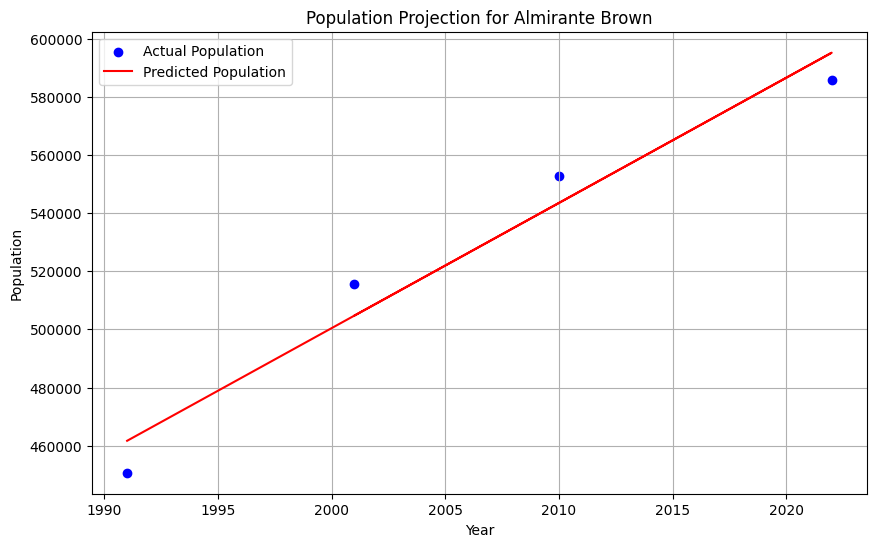

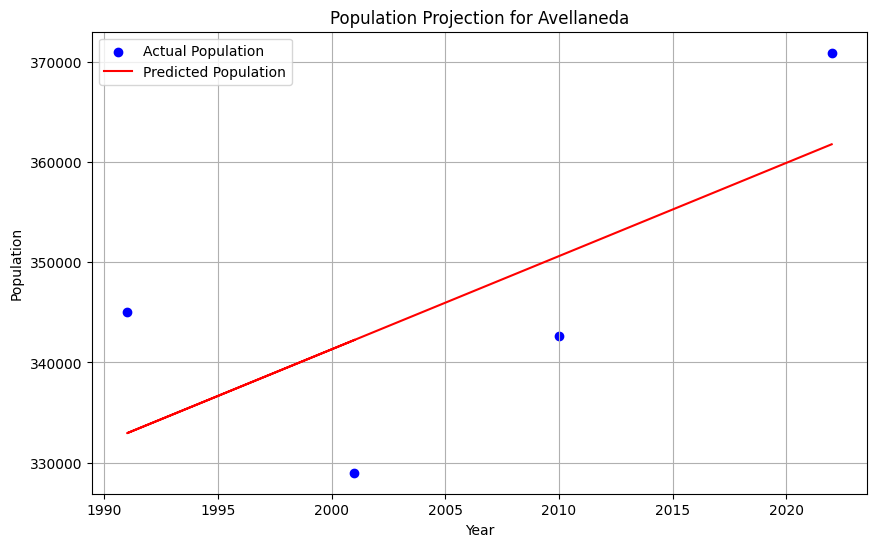

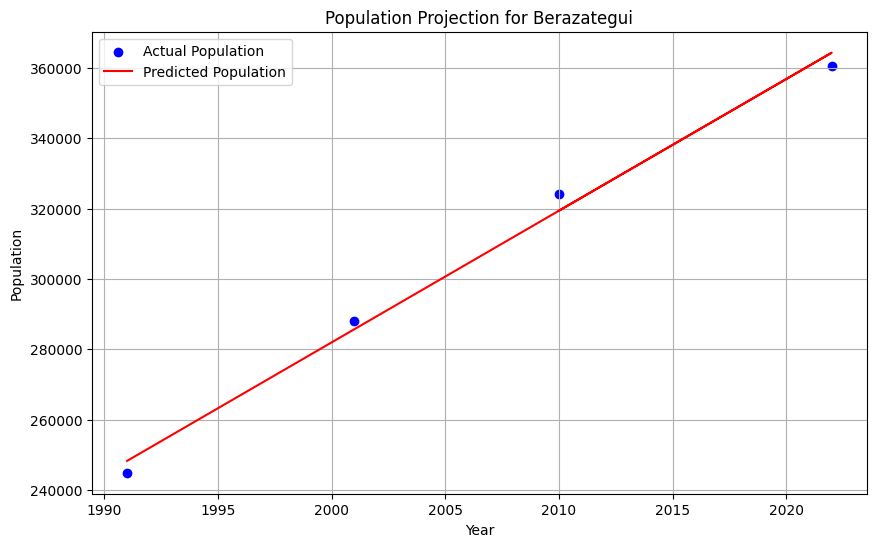

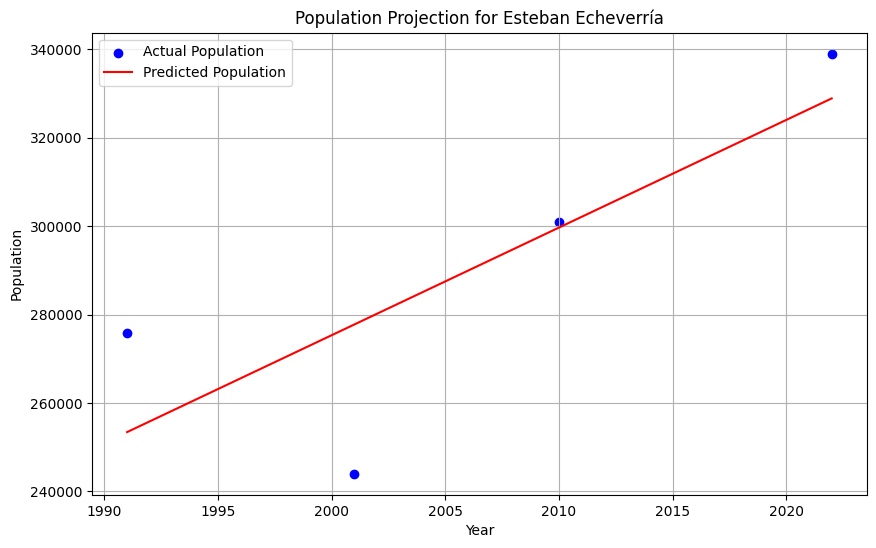

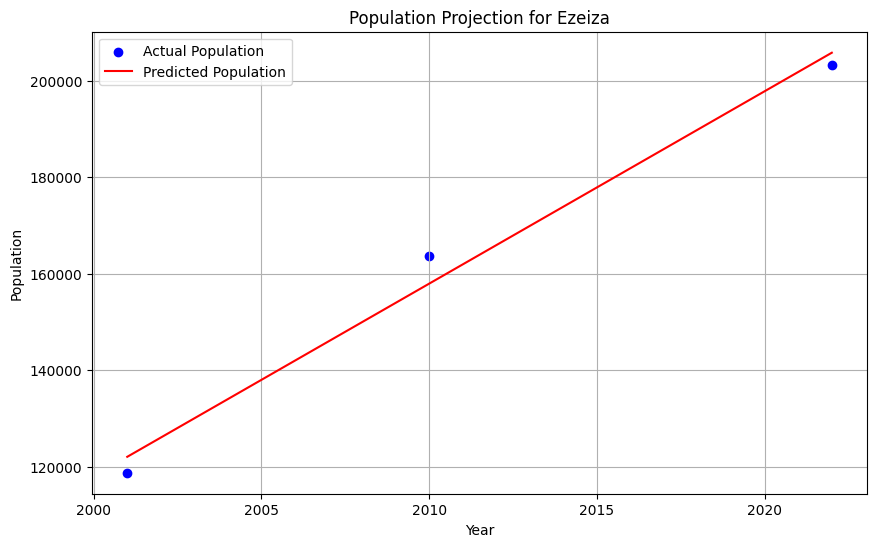

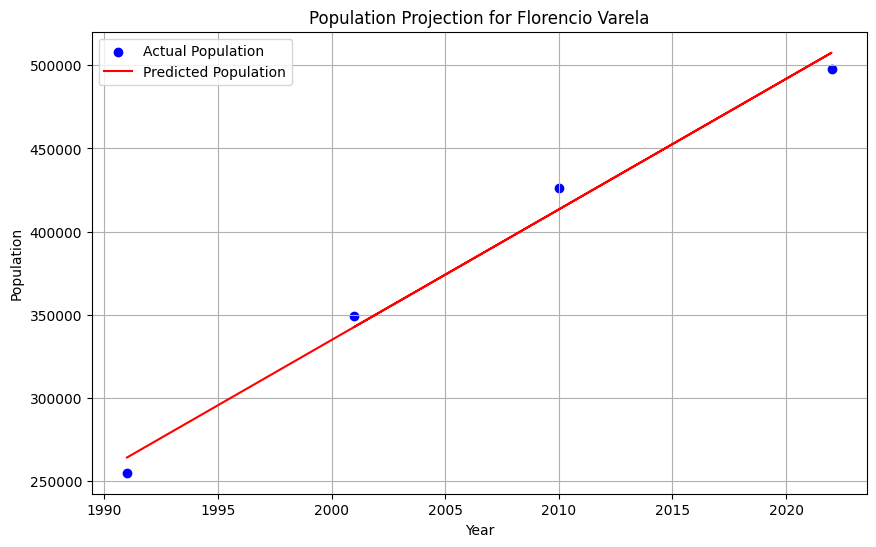

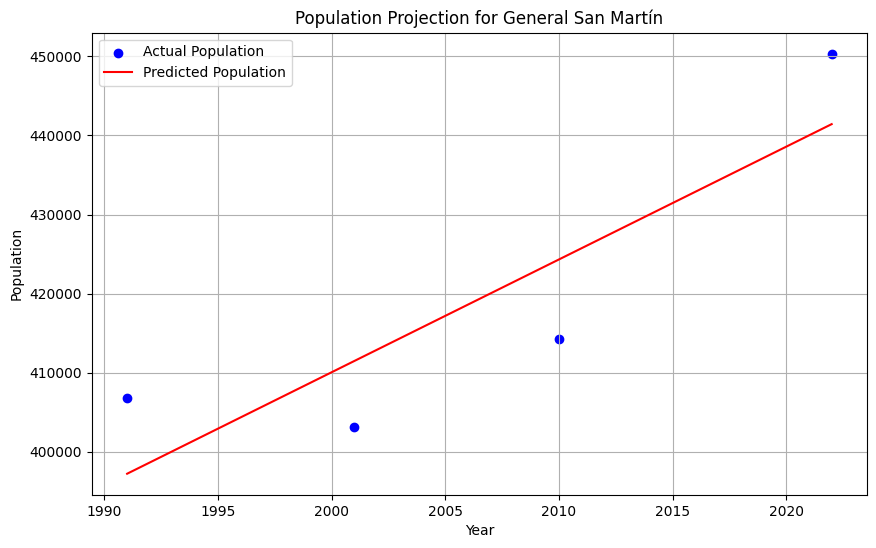

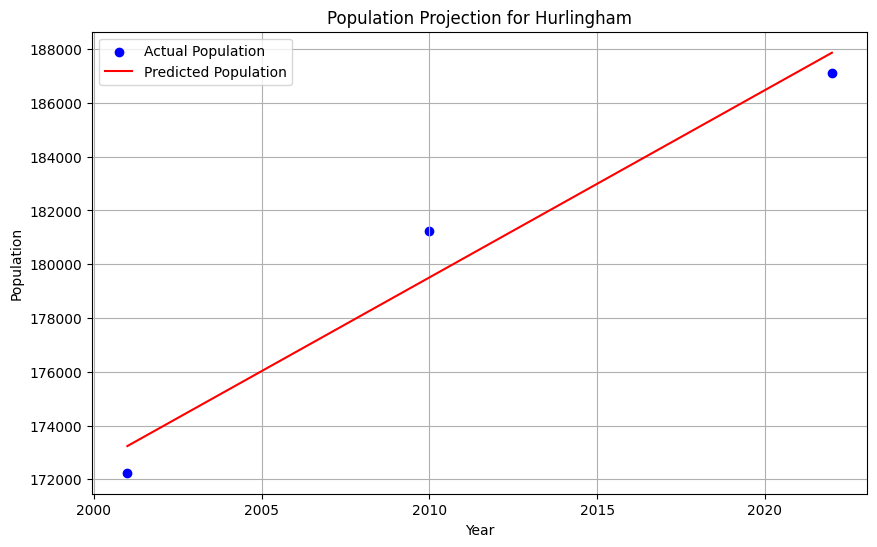

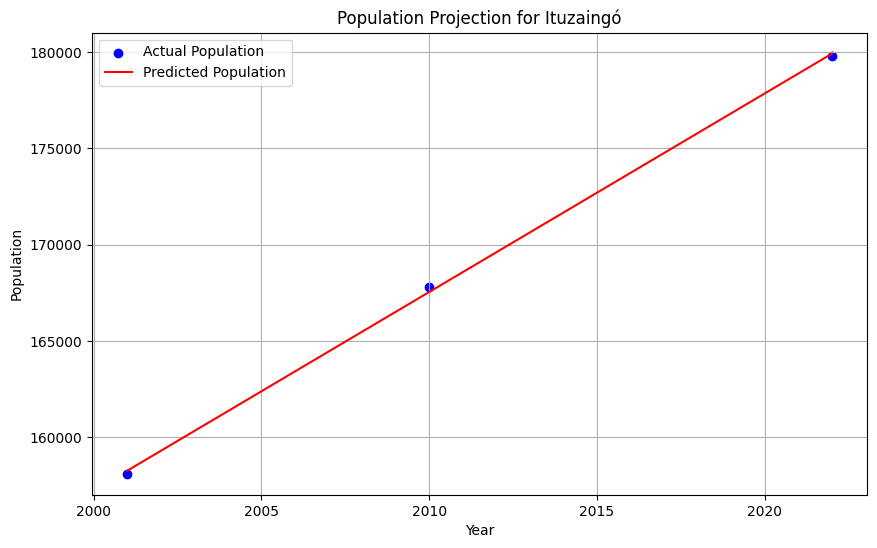

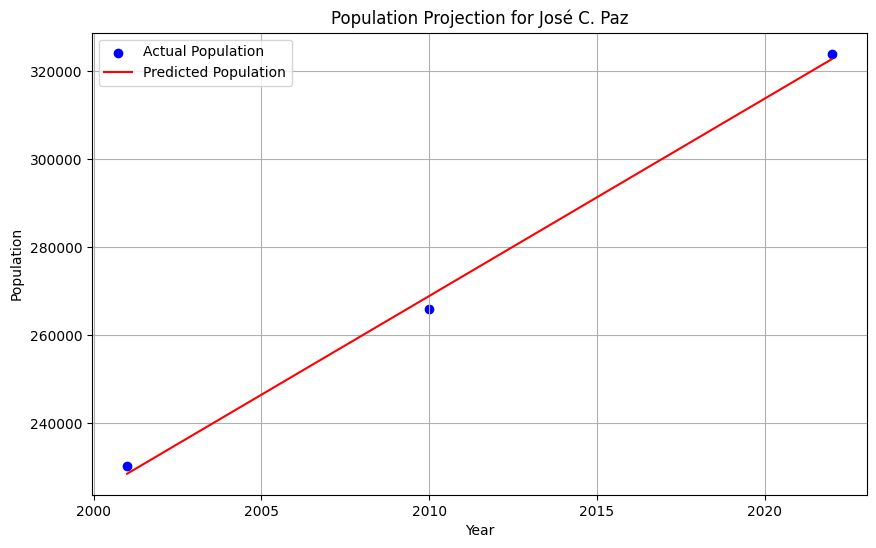

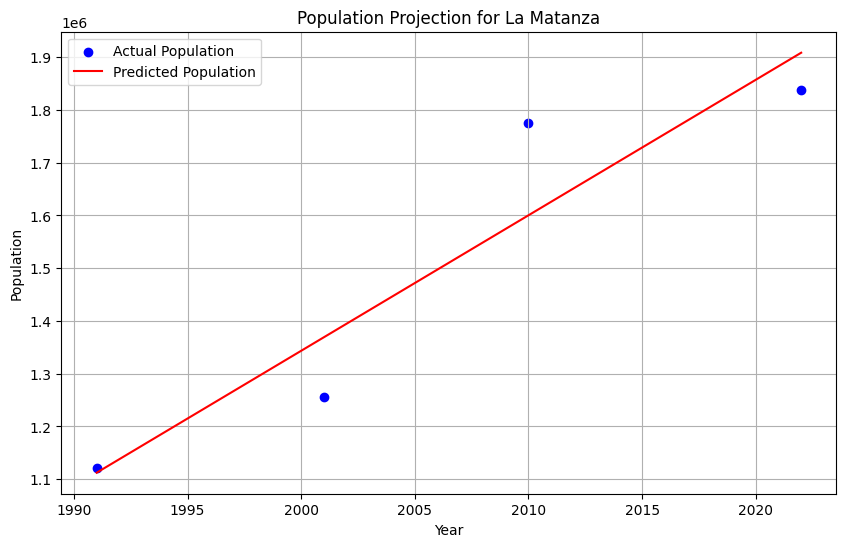

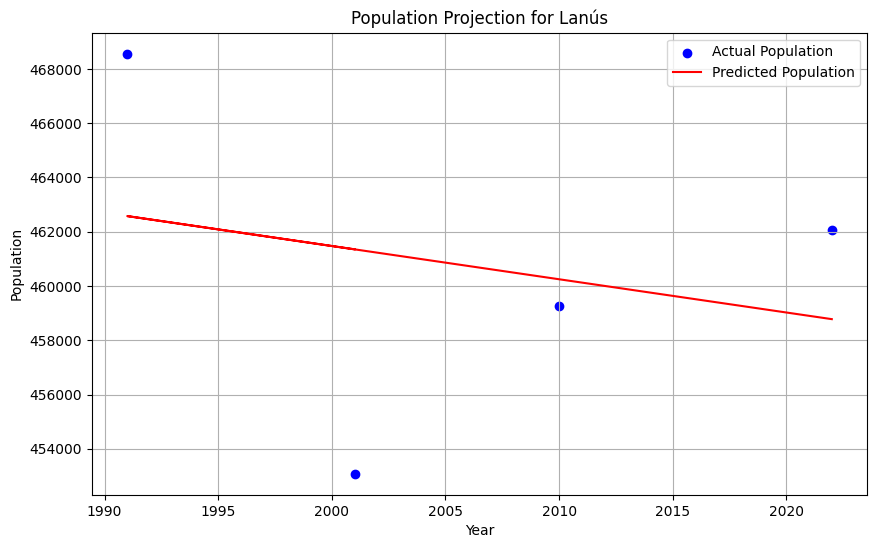

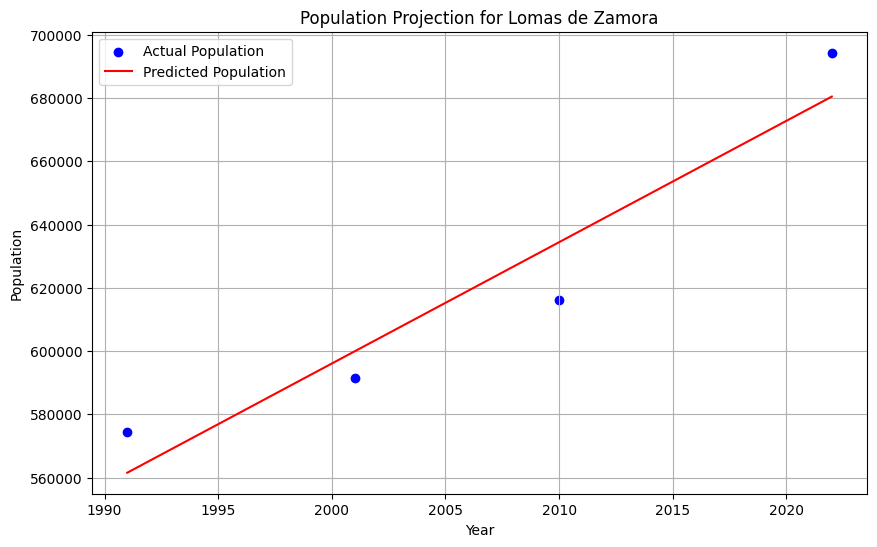

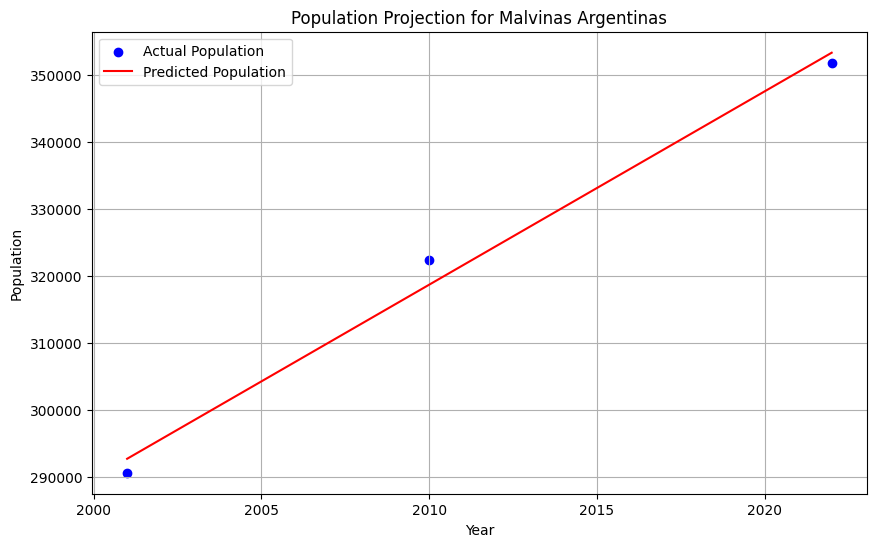

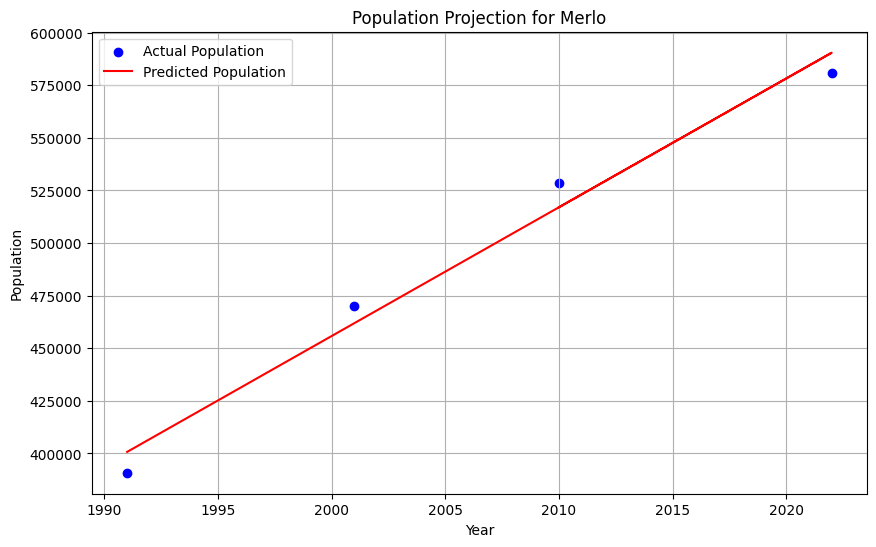

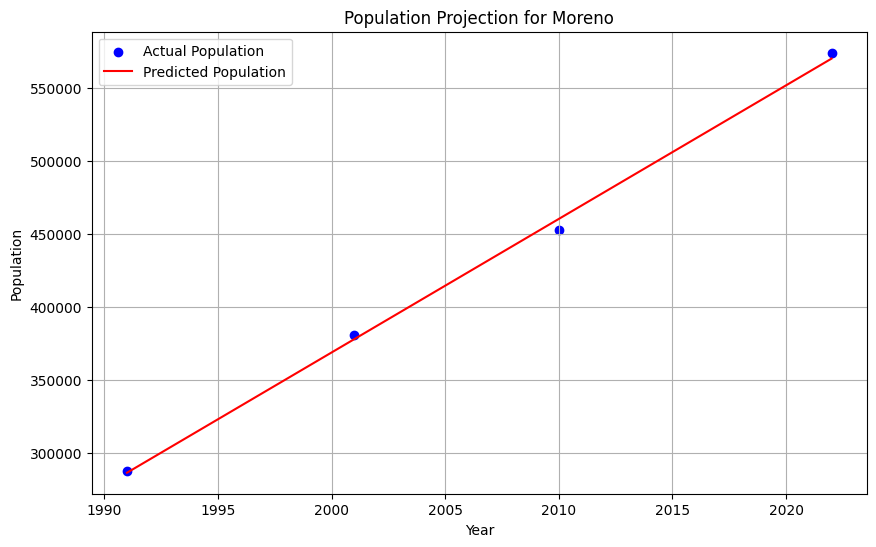

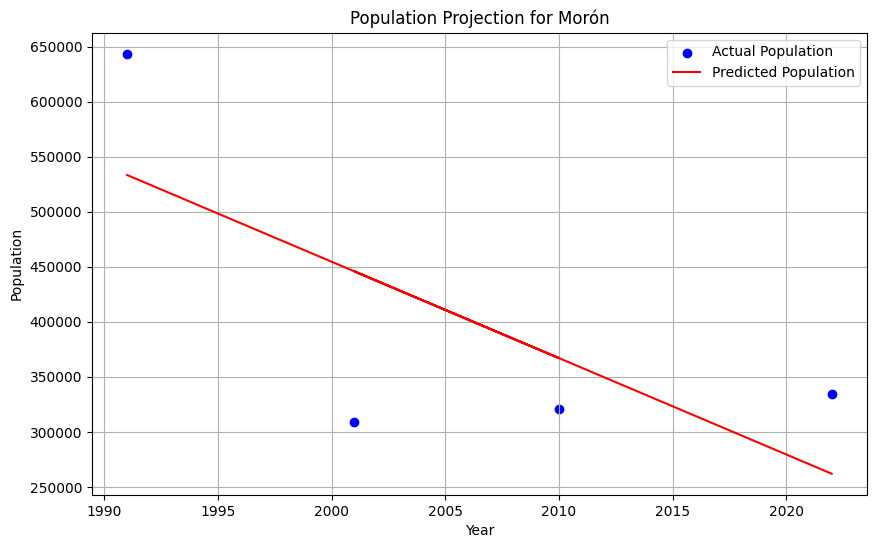

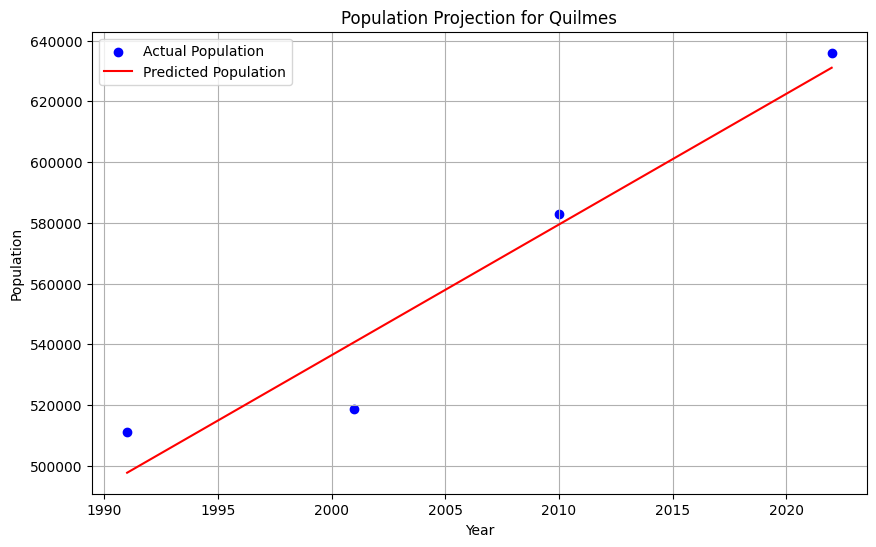

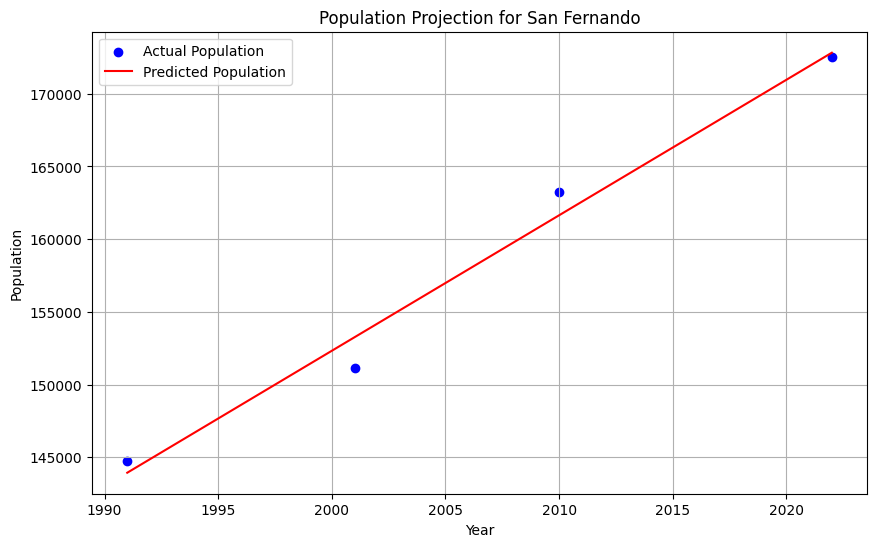

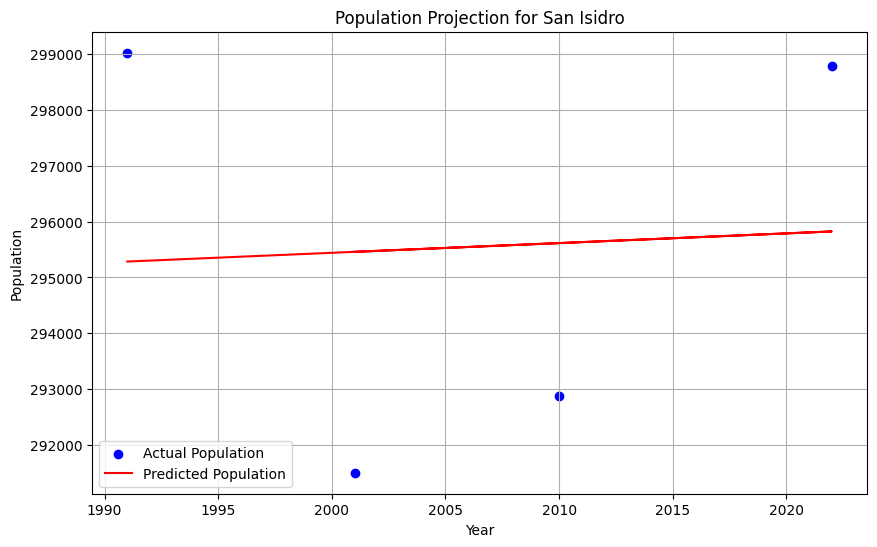

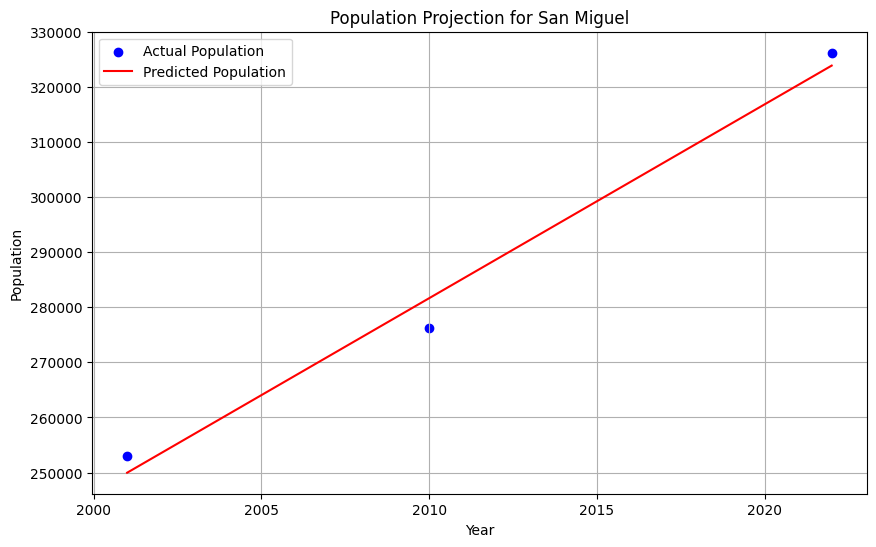

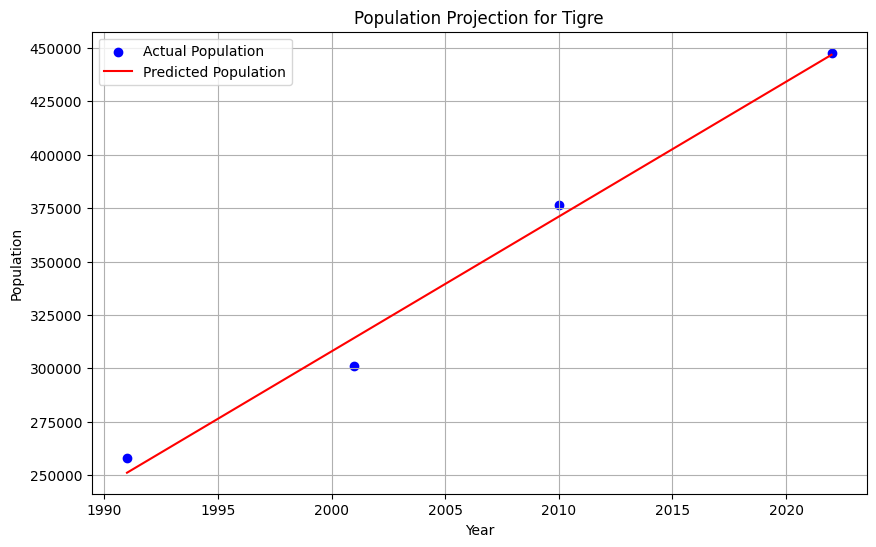

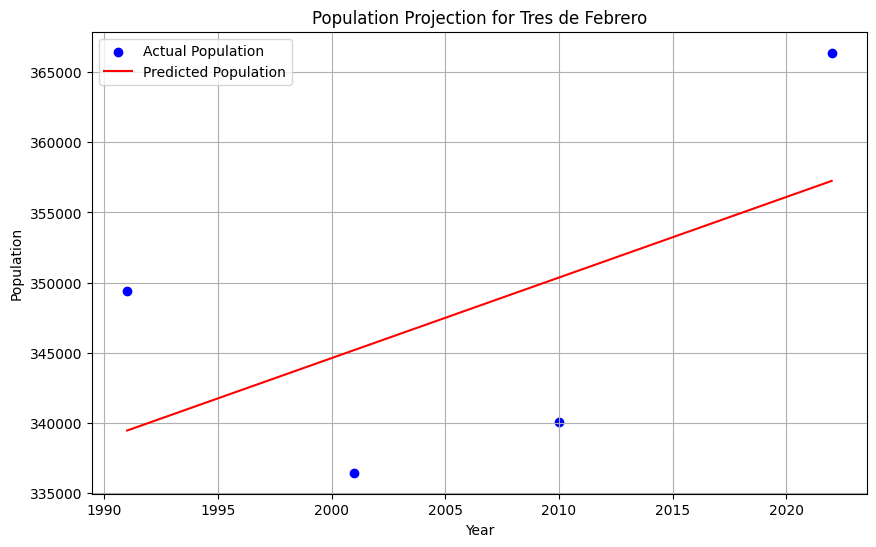

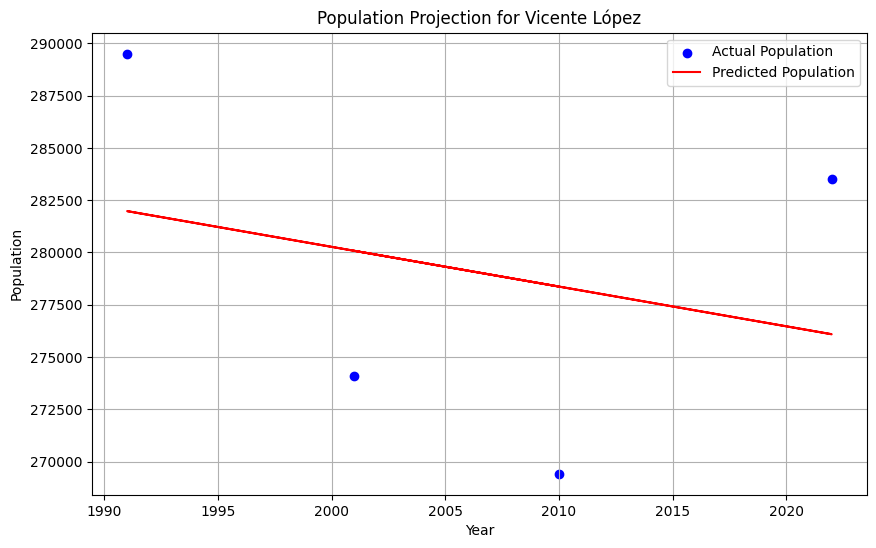

In [8]:

# Assuming df is your DataFrame containing the data
# Loop through each unique value in the 'nam' column
features=['anio']

def perform_linear_regression(df, department, features):
    # Filter DataFrame for the specified department
    df_dept = df[df['nam'] == department]
    
    # Drop rows with missing values in any of the selected features
    df_dept = df_dept.dropna(subset=features + ['pob'])
    
    # Extract the features and target variable
    X = df_dept[features].values.reshape(-1, len(features))  # Reshape X to be 2D array
    y = df_dept['pob'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict population values using the fitted model
    y_pred = model.predict(X)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(df_dept['anio'], df_dept['pob'], color='blue', label='Actual Population')
    plt.plot(df_dept['anio'], y_pred, color='red', label='Predicted Population')
    plt.title(f'Population Projection for {department}')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.show()

# Get unique department names
departments = df['nam'].unique()

# Iterate over each department and perform linear regression
for department in departments:
    perform_linear_regression(df, department, features)


### Correlation Matrix

               pob       var       muj   vivpart  vivtotal
pob       1.000000  0.999707  0.999781  0.977198  0.553735
var       0.999707  1.000000  0.999017  0.972726  0.548486
muj       0.999781  0.999017  1.000000  0.980256  0.560618
vivpart   0.977198  0.972726  0.980256  1.000000  0.582964
vivtotal  0.553735  0.548486  0.560618  0.582964  1.000000


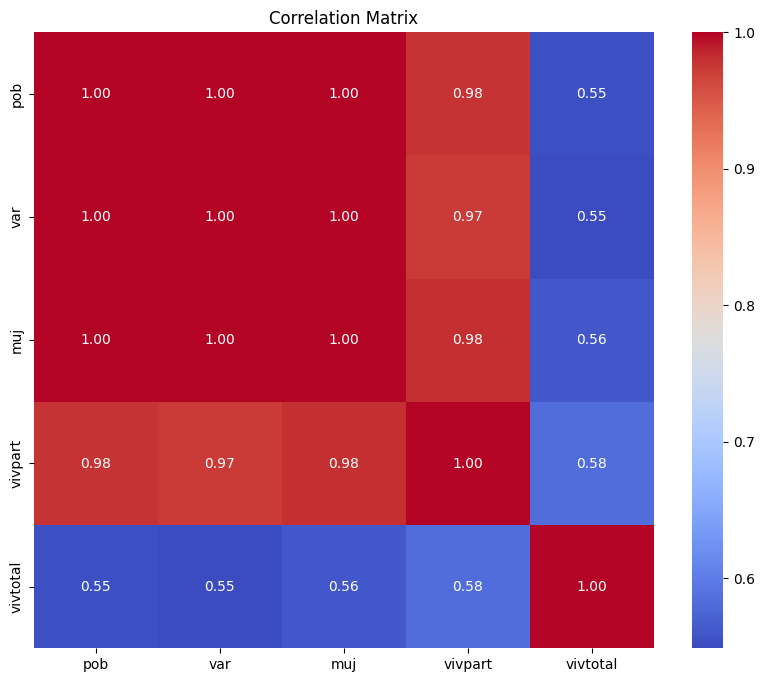

In [9]:
# Select only numeric columns for computing the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix for the numeric DataFrame
correlation_matrix = numeric_df.corr()

# Now, correlation_matrix contains the correlation matrix for the entire dataset
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


### Linear Regression fitting 1990-2010 and predicting 2022???

Forecast for Almirante Brown


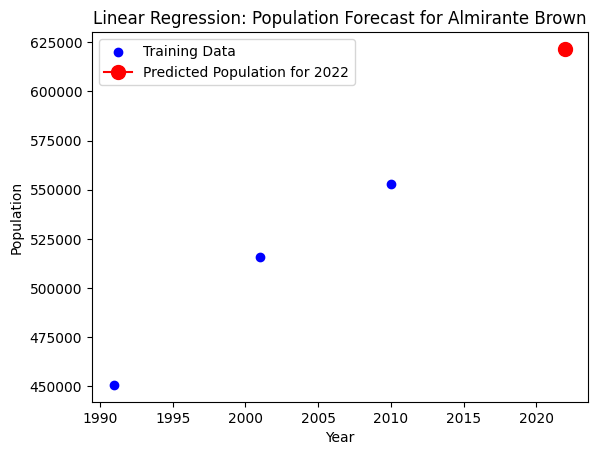

Forecast for Avellaneda


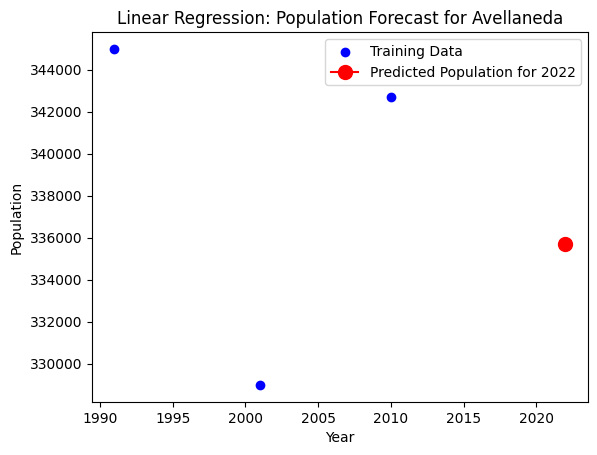

Forecast for Berazategui


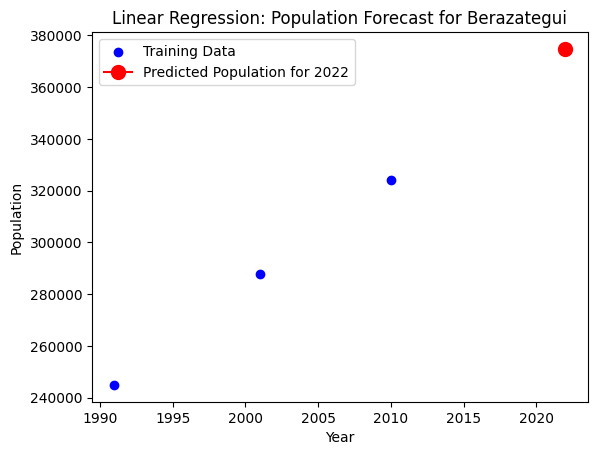

Forecast for Esteban Echeverría


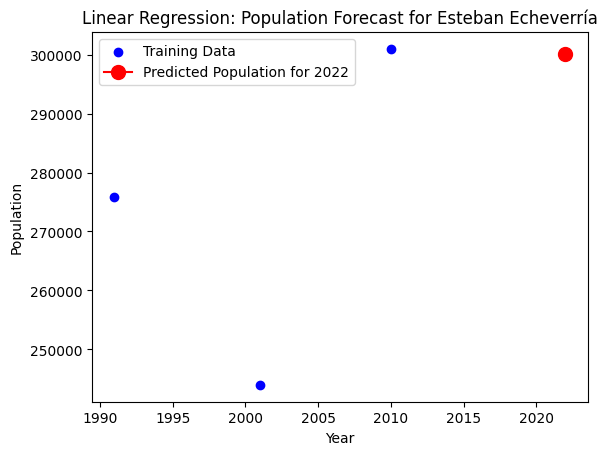

Forecast for Ezeiza


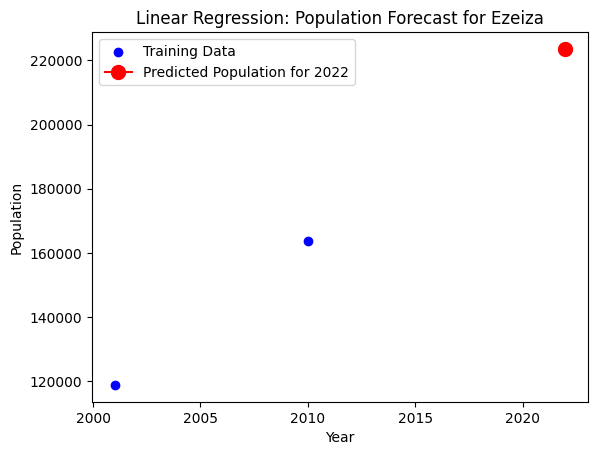

Forecast for Florencio Varela


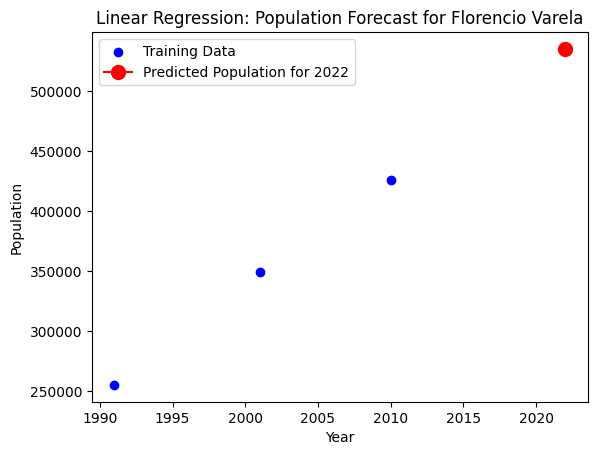

Forecast for General San Martín


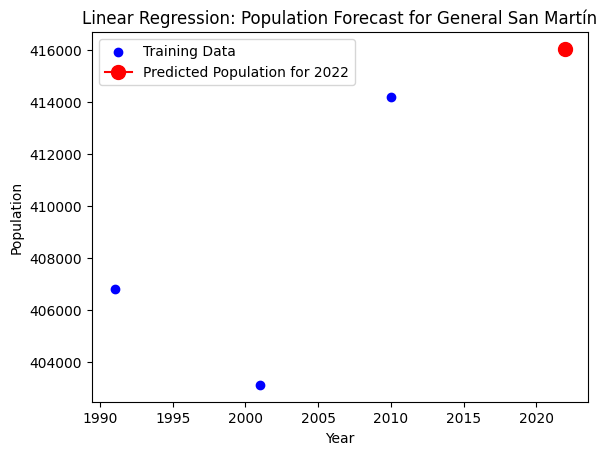

Forecast for Hurlingham


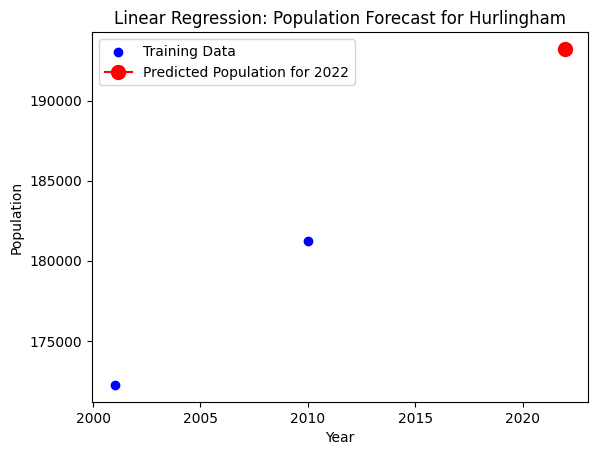

Forecast for Ituzaingó


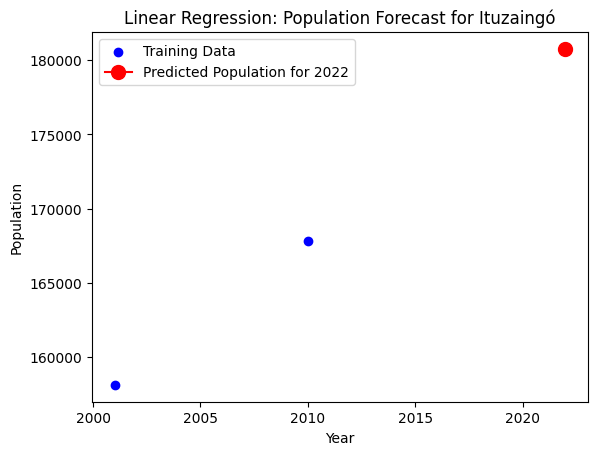

Forecast for José C. Paz


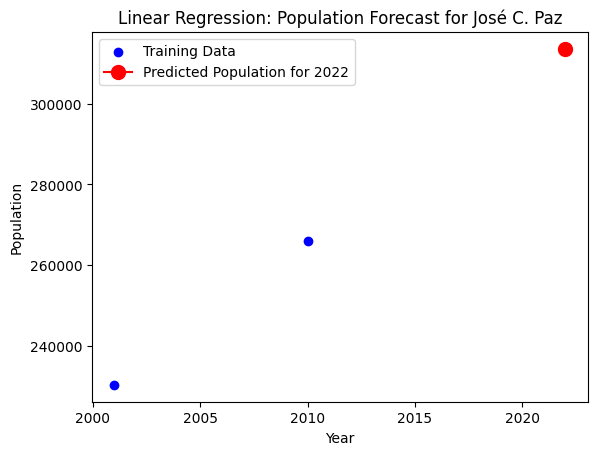

Forecast for La Matanza


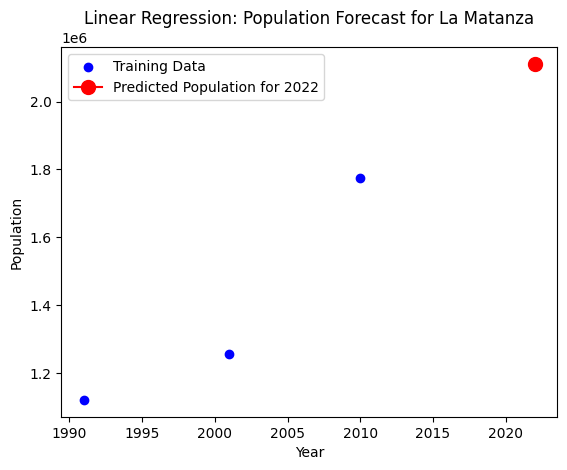

Forecast for Lanús


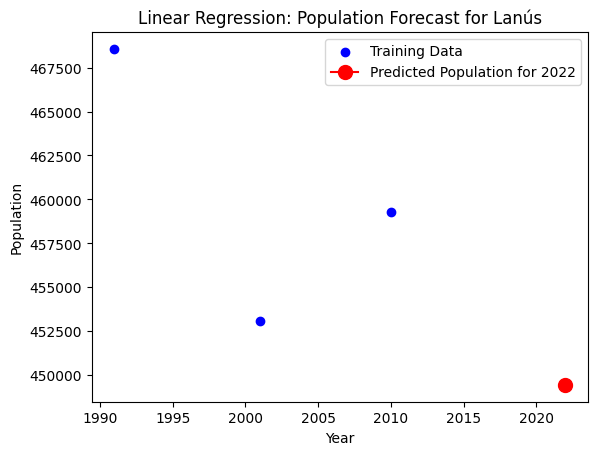

Forecast for Lomas de Zamora


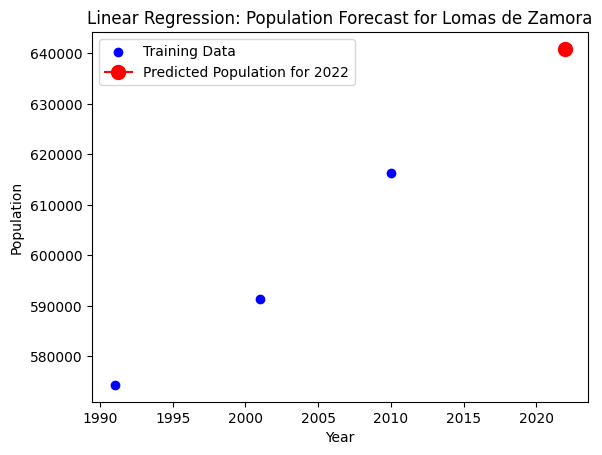

Forecast for Malvinas Argentinas


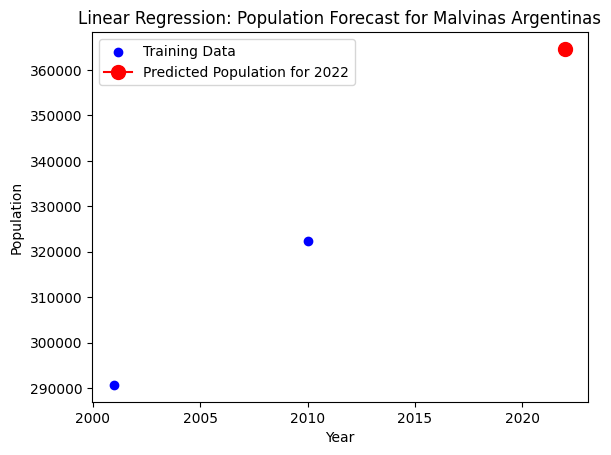

Forecast for Merlo


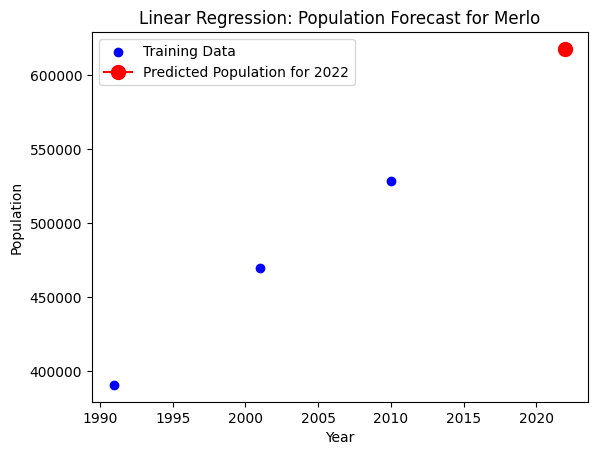

Forecast for Moreno


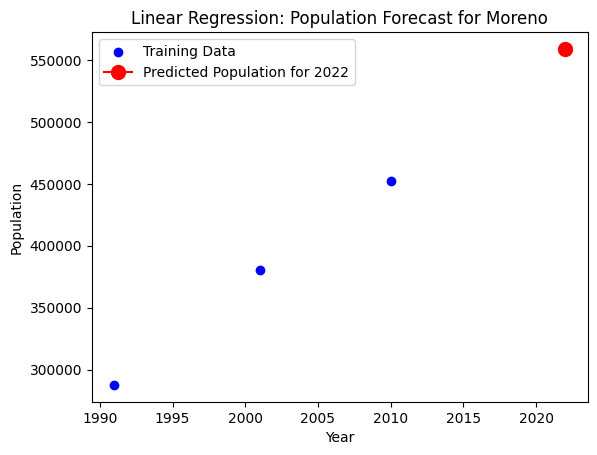

Forecast for Morón


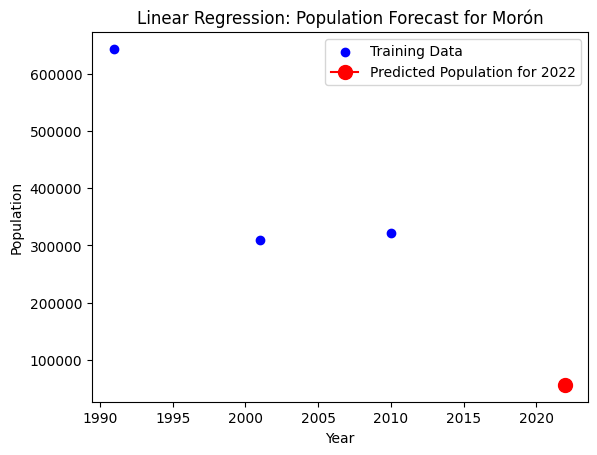

Forecast for Quilmes


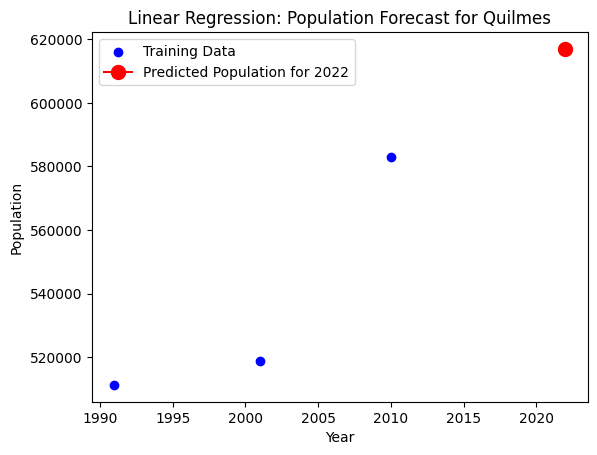

Forecast for San Fernando


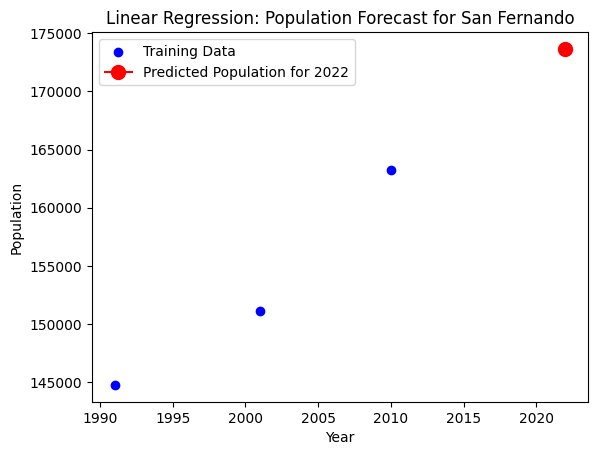

Forecast for San Isidro


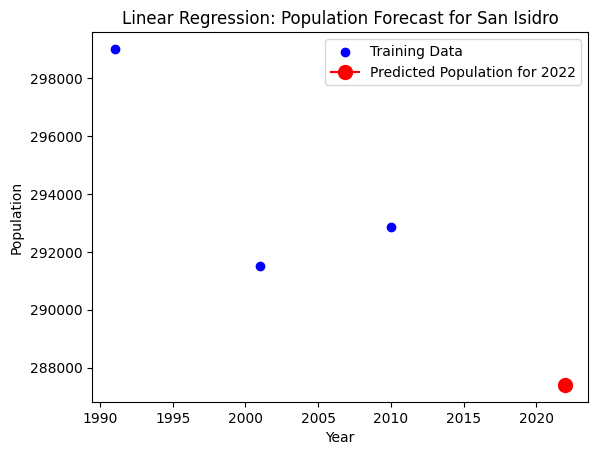

Forecast for San Miguel


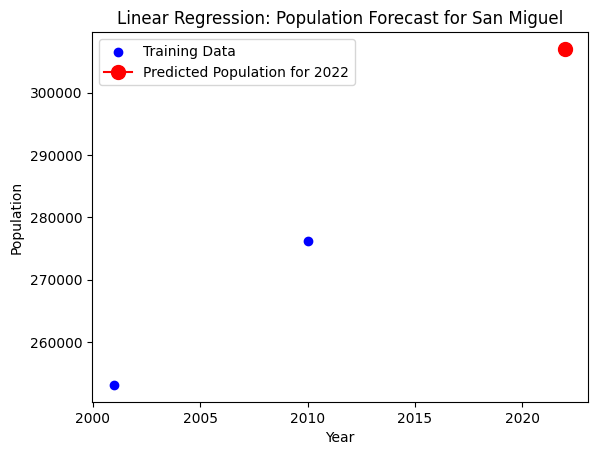

Forecast for Tigre


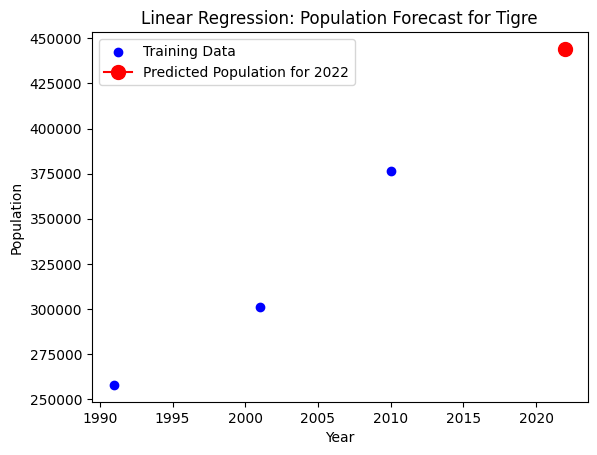

Forecast for Tres de Febrero


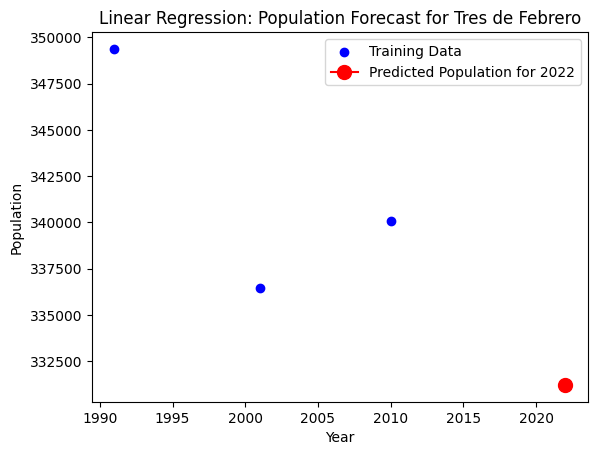

Forecast for Vicente López


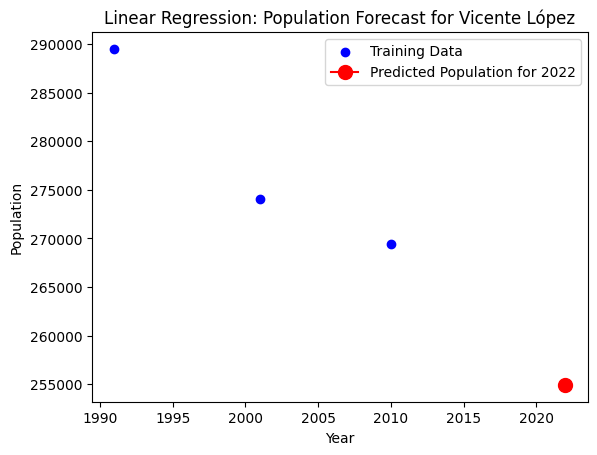

In [10]:
def linear_regression_forecast(df_group):
    # Drop rows with NaN values in the target variable 'pob'
    df_group = df_group.dropna(subset=['pob'])

    if df_group.empty:
        print("No data available for forecasting in this group.")
        return

    # Filter data for years 1990, 2001, and 2010
    X_train = df_group[df_group['anio'].isin([1991, 2001, 2010])]['anio'].values.reshape(-1, 1)
    y_train = df_group[df_group['anio'].isin([1991, 2001, 2010])]['pob'].values

    # Create and fit the Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict population for the year 2022
    X_test = [[2022]]
    y_pred = model.predict(X_test)

    # Visualize the Results
    plt.scatter(X_train, y_train, color='blue', label='Training Data')
    plt.plot(X_test, y_pred, color='red', marker='o', markersize=10, label='Predicted Population for 2022')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.title(f'Linear Regression: Population Forecast for {df_group["nam"].iloc[0]}')
    plt.legend()
    plt.show()

# Apply the linear_regression_forecast function to each 'nam' group
for name, group in df.groupby('nam'):
    print("Forecast for", name)
    linear_regression_forecast(group)


Forecast for Almirante Brown
Mean Squared Error (MSE): 283742795.1111216
Root Mean Squared Error (RMSE): 16844.666666666977
Mean Absolute Percentage Error (MAPE): 2.875242666521063%


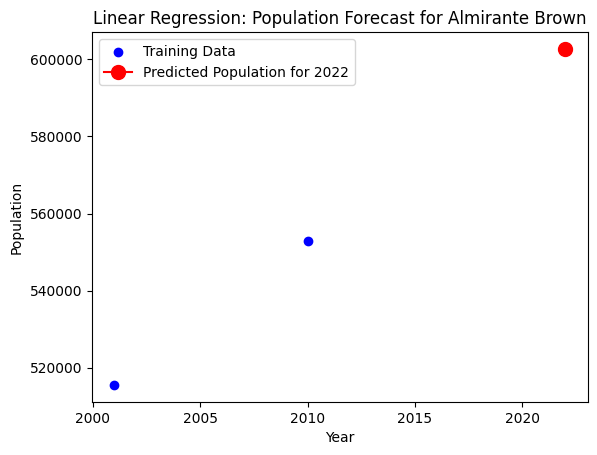

Forecast for Avellaneda
Mean Squared Error (MSE): 99986667.1111049
Root Mean Squared Error (RMSE): 9999.333333333023
Mean Absolute Percentage Error (MAPE): 2.6956813204686005%


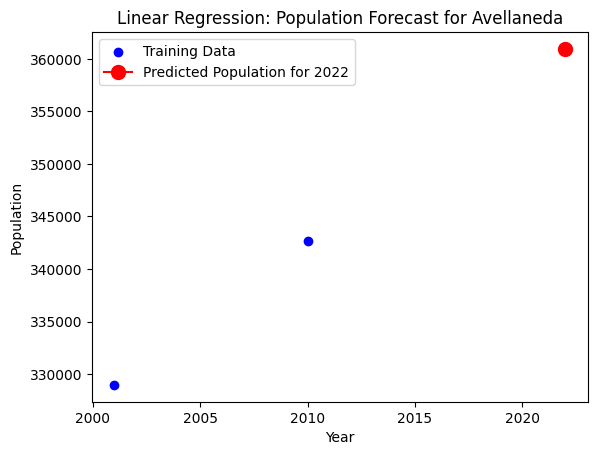

Forecast for Berazategui
Mean Squared Error (MSE): 146490677.7777928
Root Mean Squared Error (RMSE): 12103.333333333954
Mean Absolute Percentage Error (MAPE): 3.3566105167018745%


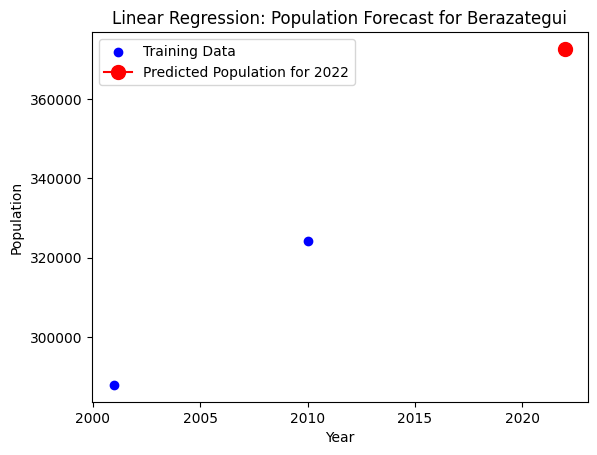

Forecast for Esteban Echeverría
Mean Squared Error (MSE): 1437092281.0
Root Mean Squared Error (RMSE): 37909.0
Mean Absolute Percentage Error (MAPE): 11.18160634752087%


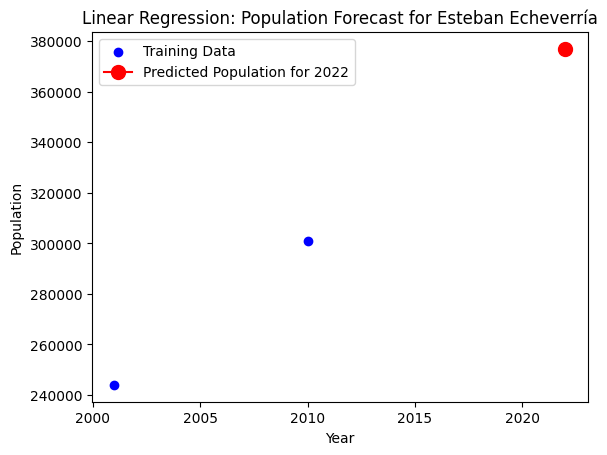

Forecast for Ezeiza
Mean Squared Error (MSE): 413132725.4444949
Root Mean Squared Error (RMSE): 20325.66666666791
Mean Absolute Percentage Error (MAPE): 9.998704597368157%


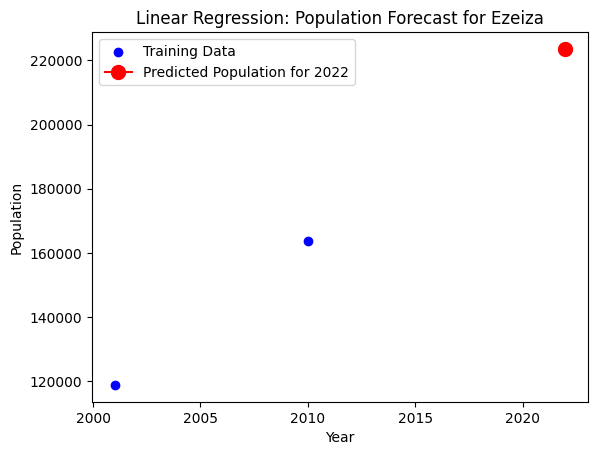

Forecast for Florencio Varela
Mean Squared Error (MSE): 954830600.1110344
Root Mean Squared Error (RMSE): 30900.33333333209
Mean Absolute Percentage Error (MAPE): 6.20715468973241%


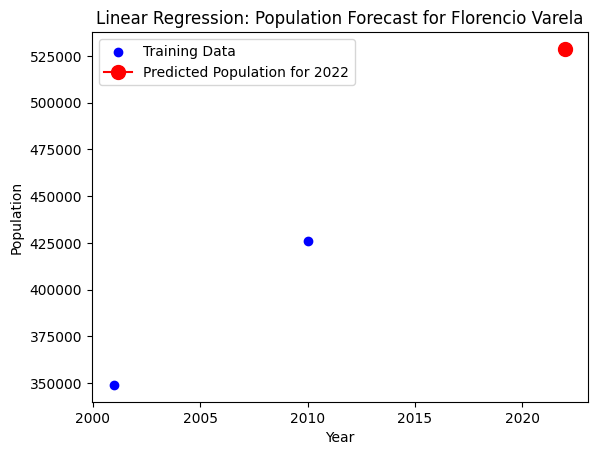

Forecast for General San Martín
Mean Squared Error (MSE): 455979080.1111244
Root Mean Squared Error (RMSE): 21353.666666666977
Mean Absolute Percentage Error (MAPE): 4.741729305220997%


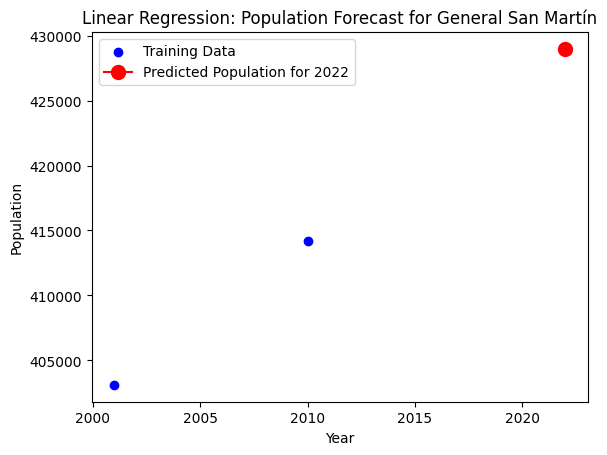

Forecast for Hurlingham
Mean Squared Error (MSE): 37376920.11110921
Root Mean Squared Error (RMSE): 6113.666666666511
Mean Absolute Percentage Error (MAPE): 3.267208915395577%


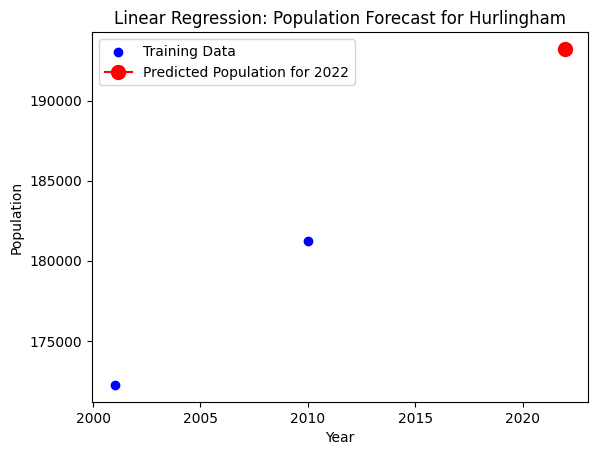

Forecast for Ituzaingó
Mean Squared Error (MSE): 947377.7777771734
Root Mean Squared Error (RMSE): 973.3333333330229
Mean Absolute Percentage Error (MAPE): 0.5413783641472306%


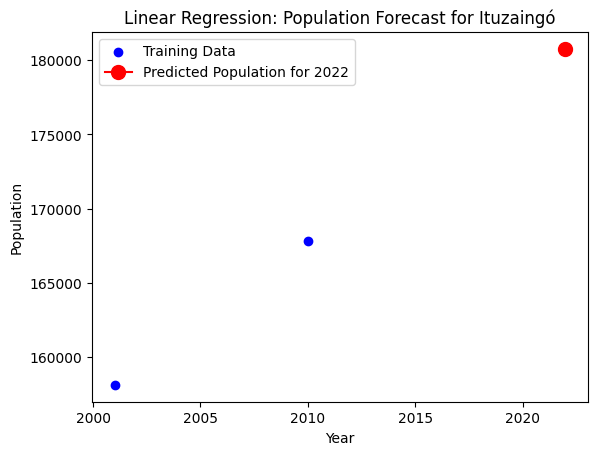

Forecast for José C. Paz
Mean Squared Error (MSE): 104850773.44443172
Root Mean Squared Error (RMSE): 10239.666666666046
Mean Absolute Percentage Error (MAPE): 3.161191001014468%


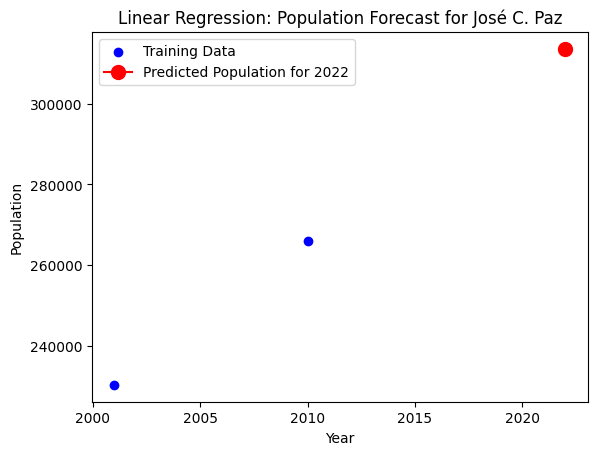

Forecast for La Matanza
Mean Squared Error (MSE): 399524283627.12366
Root Mean Squared Error (RMSE): 632079.3333333433
Mean Absolute Percentage Error (MAPE): 34.39374663769012%


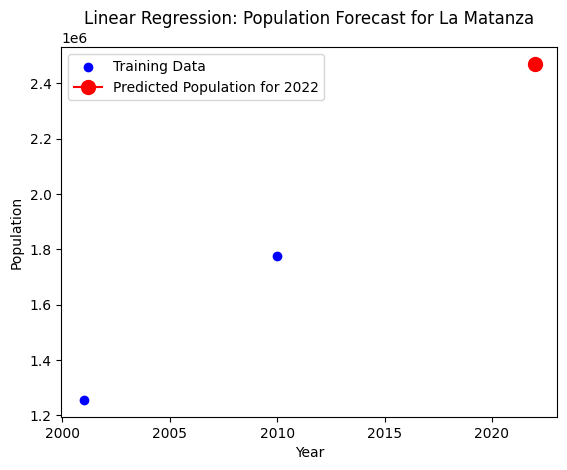

Forecast for Lanús
Mean Squared Error (MSE): 29738844.4444436
Root Mean Squared Error (RMSE): 5453.333333333256
Mean Absolute Percentage Error (MAPE): 1.1802448936011947%


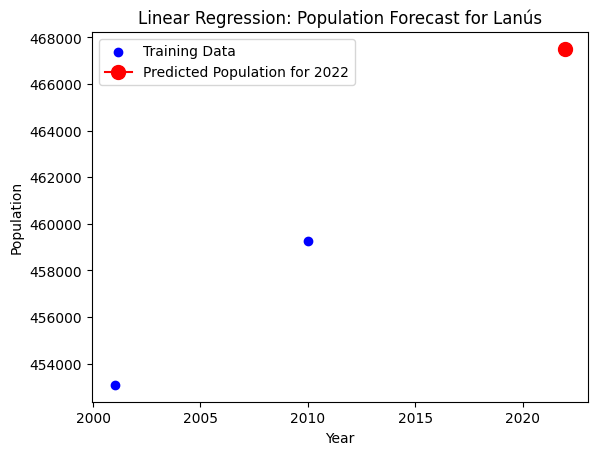

Forecast for Lomas de Zamora
Mean Squared Error (MSE): 2007547765.4444723
Root Mean Squared Error (RMSE): 44805.66666666698
Mean Absolute Percentage Error (MAPE): 6.453079467496288%


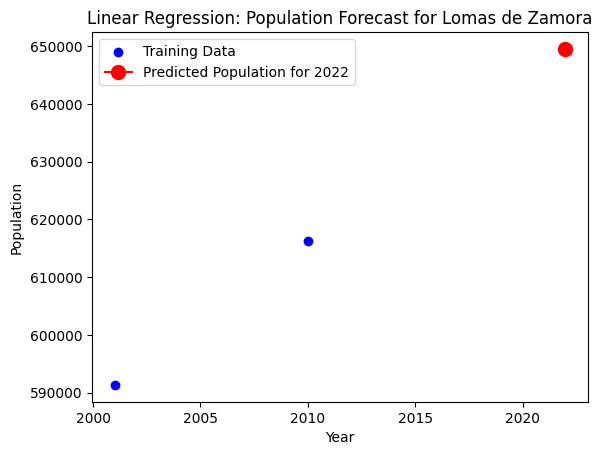

Forecast for Malvinas Argentinas
Mean Squared Error (MSE): 164668778.7777698
Root Mean Squared Error (RMSE): 12832.333333333023
Mean Absolute Percentage Error (MAPE): 3.6477461804646616%


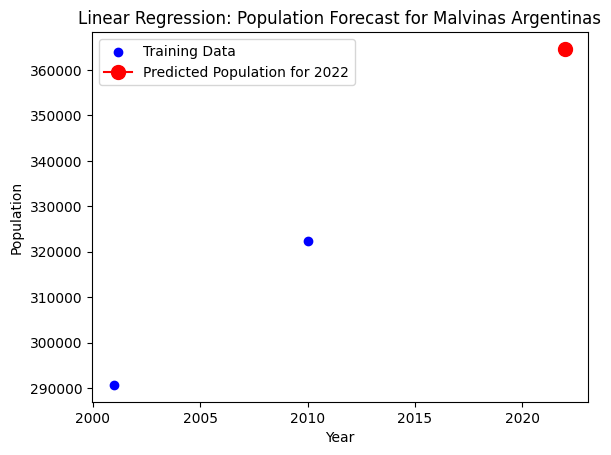

Forecast for Merlo
Mean Squared Error (MSE): 660490000.0
Root Mean Squared Error (RMSE): 25700.0
Mean Absolute Percentage Error (MAPE): 4.4248854178503665%


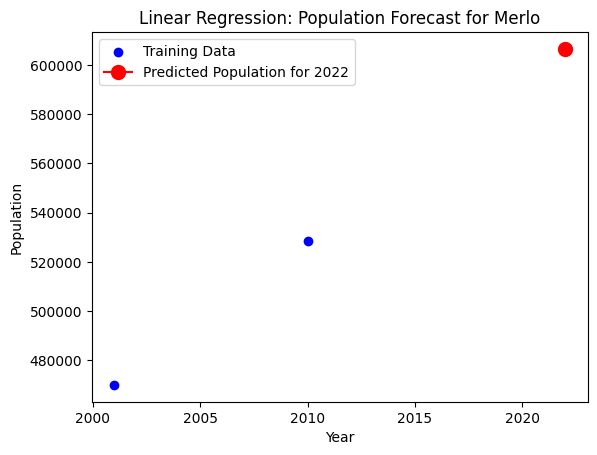

Forecast for Moreno
Mean Squared Error (MSE): 669067200.1111432
Root Mean Squared Error (RMSE): 25866.333333333954
Mean Absolute Percentage Error (MAPE): 4.503395580812146%


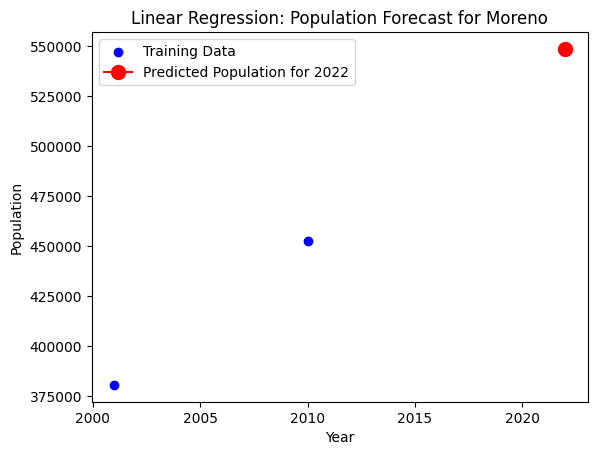

Forecast for Morón
Mean Squared Error (MSE): 6603186.77777698
Root Mean Squared Error (RMSE): 2569.6666666665114
Mean Absolute Percentage Error (MAPE): 0.7689514769573436%


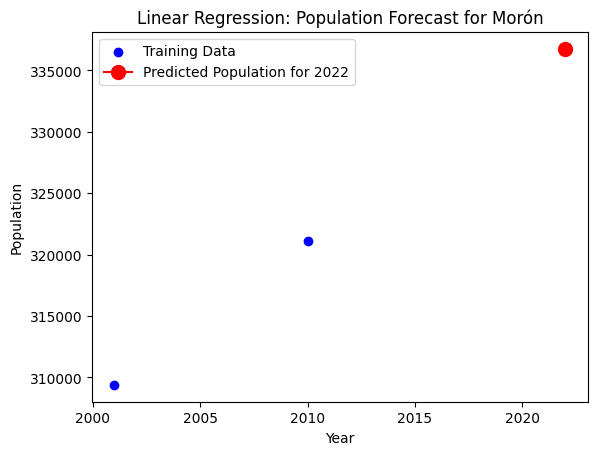

Forecast for Quilmes
Mean Squared Error (MSE): 1053456849.0
Root Mean Squared Error (RMSE): 32457.0
Mean Absolute Percentage Error (MAPE): 5.10309326977199%


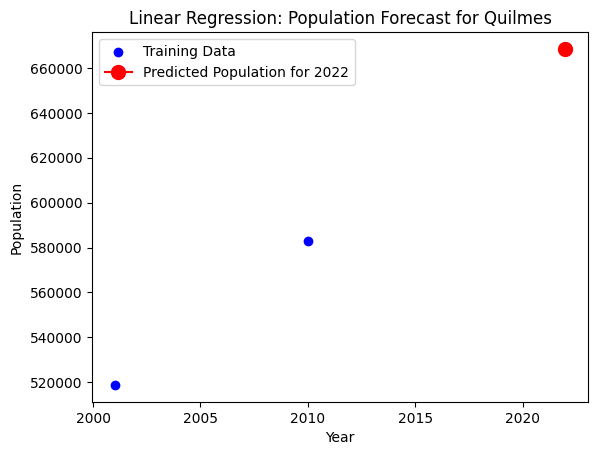

Forecast for San Fernando
Mean Squared Error (MSE): 47077895.11111324
Root Mean Squared Error (RMSE): 6861.333333333489
Mean Absolute Percentage Error (MAPE): 3.9770312149808076%


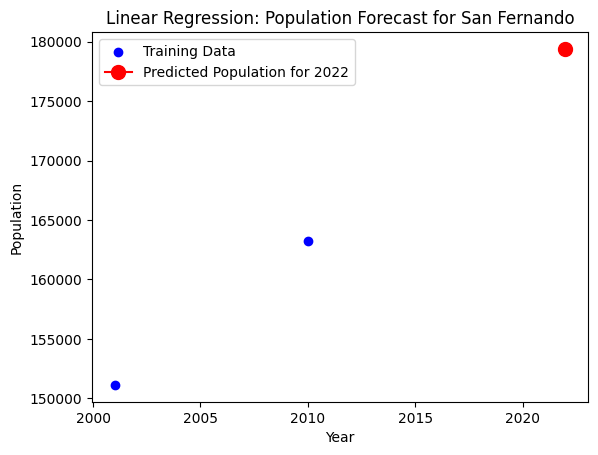

Forecast for San Isidro
Mean Squared Error (MSE): 16551336.111110954
Root Mean Squared Error (RMSE): 4068.333333333314
Mean Absolute Percentage Error (MAPE): 1.361662153824864%


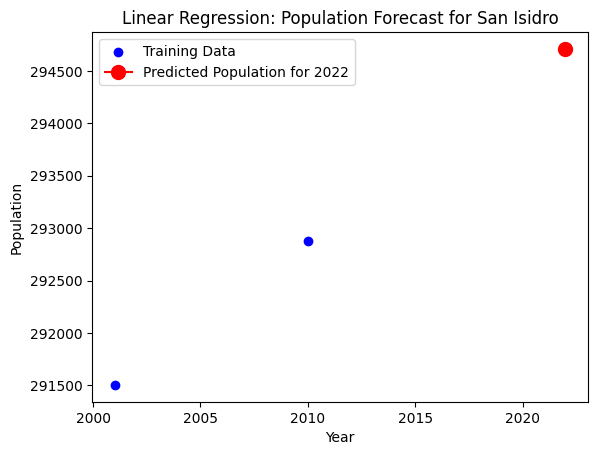

Forecast for San Miguel
Mean Squared Error (MSE): 369395586.7777897
Root Mean Squared Error (RMSE): 19219.666666666977
Mean Absolute Percentage Error (MAPE): 5.891717629988498%


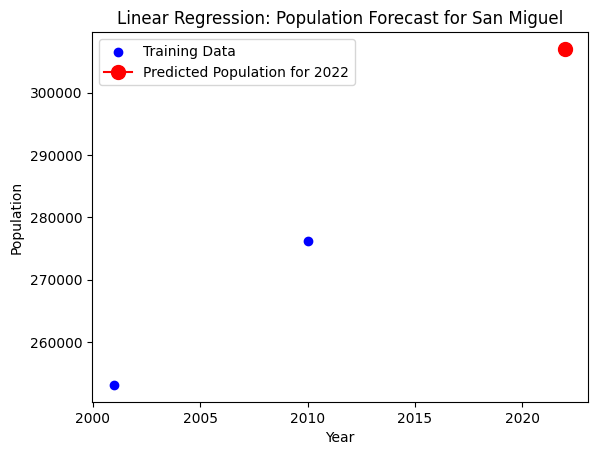

Forecast for Tigre
Mean Squared Error (MSE): 829824044.4444087
Root Mean Squared Error (RMSE): 28806.666666666046
Mean Absolute Percentage Error (MAPE): 6.433146859914031%


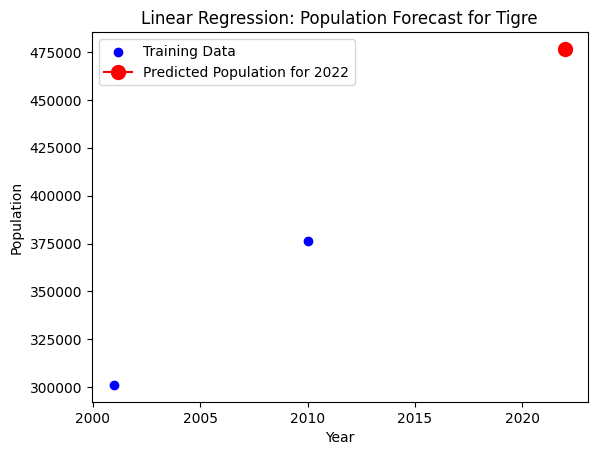

Forecast for Tres de Febrero
Mean Squared Error (MSE): 462278667.11110944
Root Mean Squared Error (RMSE): 21500.666666666628
Mean Absolute Percentage Error (MAPE): 5.8684542606841115%


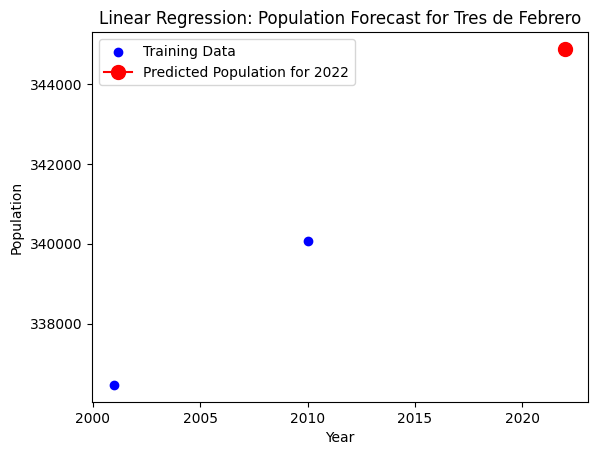

Forecast for Vicente López
Mean Squared Error (MSE): 412333636.0
Root Mean Squared Error (RMSE): 20306.0
Mean Absolute Percentage Error (MAPE): 7.162357588797573%


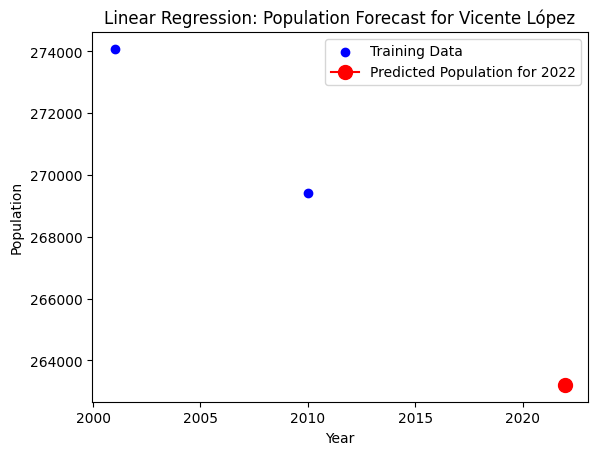

In [11]:

def linear_regression_forecast(df_group):
    # Drop rows with NaN values in the target variable 'pob'
    df_group = df_group.dropna(subset=['pob'])

    if df_group.empty:
        print("No data available for forecasting in this group.")
        return

    # Filter data for years 1990, 2001, and 2010
    X_train = df_group[df_group['anio'].isin([1990, 2001, 2010])]['anio'].values.reshape(-1, 1)
    y_train = df_group[df_group['anio'].isin([1990, 2001, 2010])]['pob'].values

    # Create and fit the Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict population for the year 2022
    X_test = [[2022]]
    y_pred = model.predict(X_test)

    # Calculate metrics
    actual_population_2022 = df_group[df_group['anio'] == 2022]['pob'].values
    mse = mean_squared_error(actual_population_2022, y_pred)
    rmse = np.sqrt(mse)
    MAPE = np.mean(np.abs((actual_population_2022 - y_pred) / actual_population_2022)) * 100

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {MAPE}%")

    # Visualize the Results
    plt.scatter(X_train, y_train, color='blue', label='Training Data')
    plt.plot(X_test, y_pred, color='red', marker='o', markersize=10, label='Predicted Population for 2022')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.title(f'Linear Regression: Population Forecast for {df_group["nam"].iloc[0]}')
    plt.legend()
    plt.show()

# Apply the linear_regression_forecast function to each 'nam' group
for name, group in df.groupby('nam'):
    print("Forecast for", name)
    linear_regression_forecast(group)



#### Not creatint the dataset properly - code below


Mean Squared Error (MSE): 283742795.1111216
Root Mean Squared Error (RMSE): 16844.666666666977
Mean Absolute Percentage Error (MAPE): 2.875242666521063%


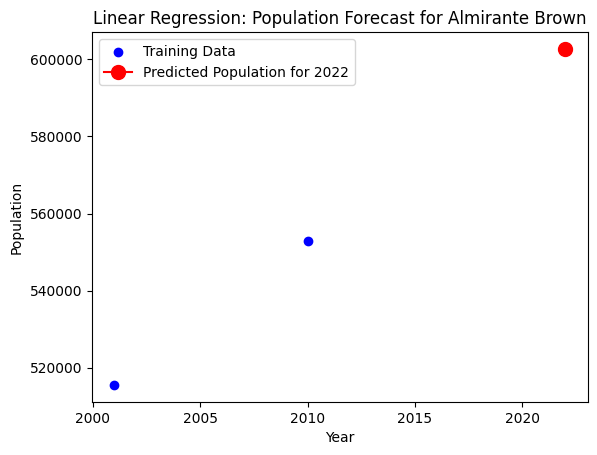

Mean Squared Error (MSE): 99986667.1111049
Root Mean Squared Error (RMSE): 9999.333333333023
Mean Absolute Percentage Error (MAPE): 2.6956813204686005%


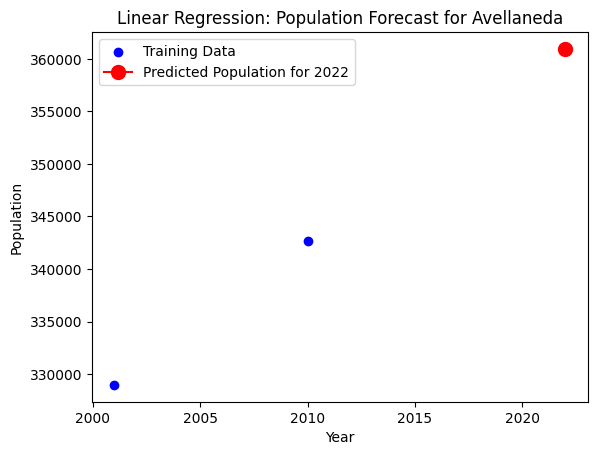

Mean Squared Error (MSE): 146490677.7777928
Root Mean Squared Error (RMSE): 12103.333333333954
Mean Absolute Percentage Error (MAPE): 3.3566105167018745%


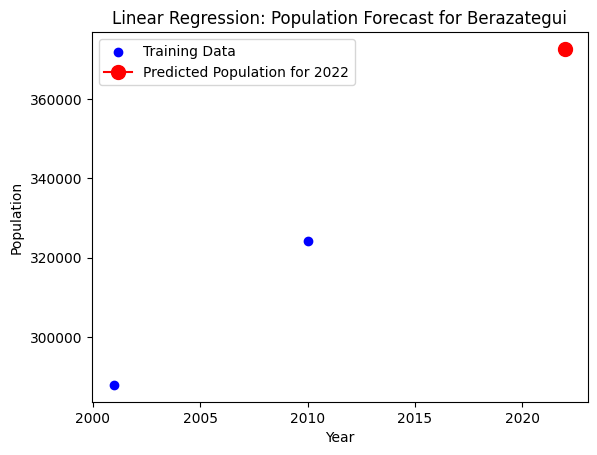

Mean Squared Error (MSE): 1437092281.0
Root Mean Squared Error (RMSE): 37909.0
Mean Absolute Percentage Error (MAPE): 11.18160634752087%


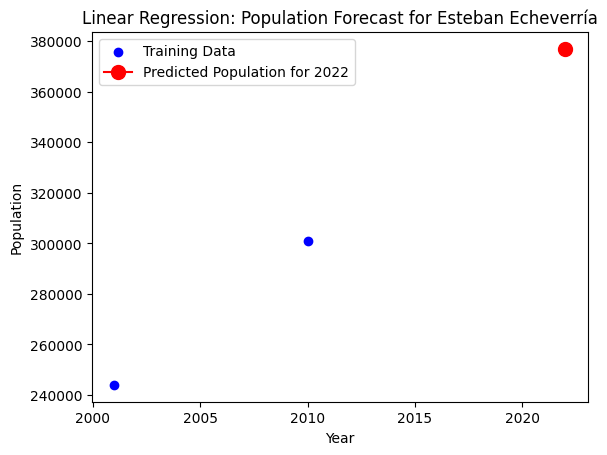

Mean Squared Error (MSE): 413132725.4444949
Root Mean Squared Error (RMSE): 20325.66666666791
Mean Absolute Percentage Error (MAPE): 9.998704597368157%


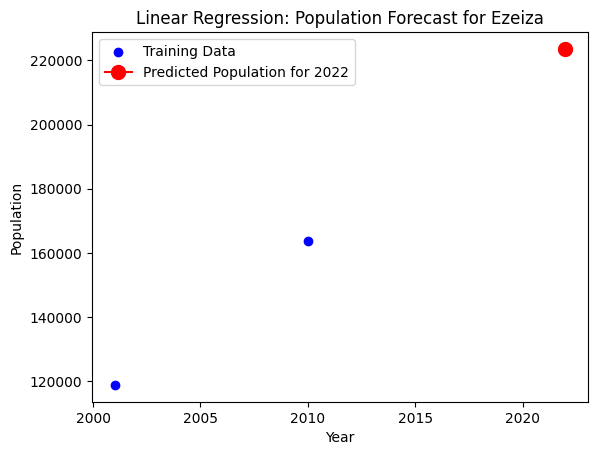

Mean Squared Error (MSE): 954830600.1110344
Root Mean Squared Error (RMSE): 30900.33333333209
Mean Absolute Percentage Error (MAPE): 6.20715468973241%


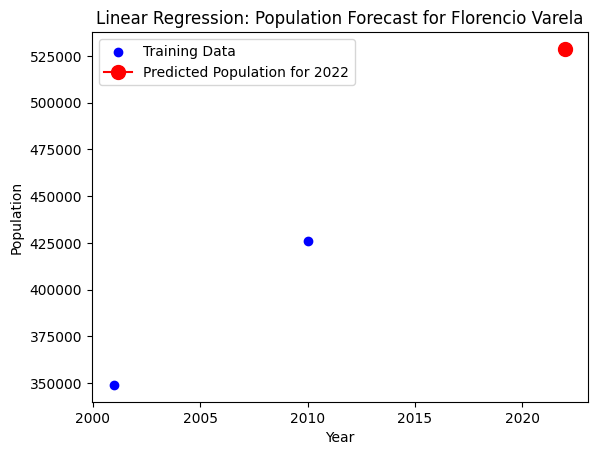

Mean Squared Error (MSE): 455979080.1111244
Root Mean Squared Error (RMSE): 21353.666666666977
Mean Absolute Percentage Error (MAPE): 4.741729305220997%


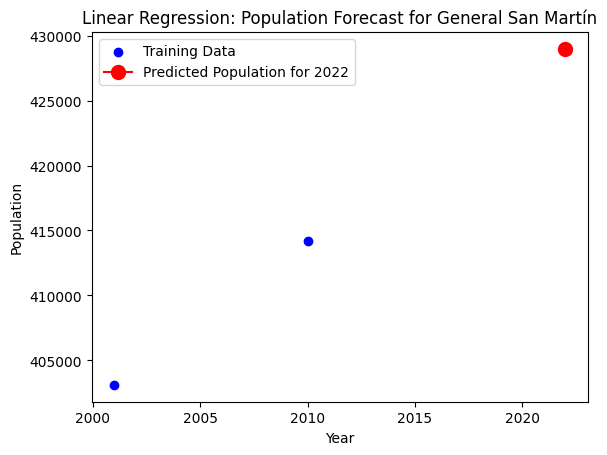

Mean Squared Error (MSE): 37376920.11110921
Root Mean Squared Error (RMSE): 6113.666666666511
Mean Absolute Percentage Error (MAPE): 3.267208915395577%


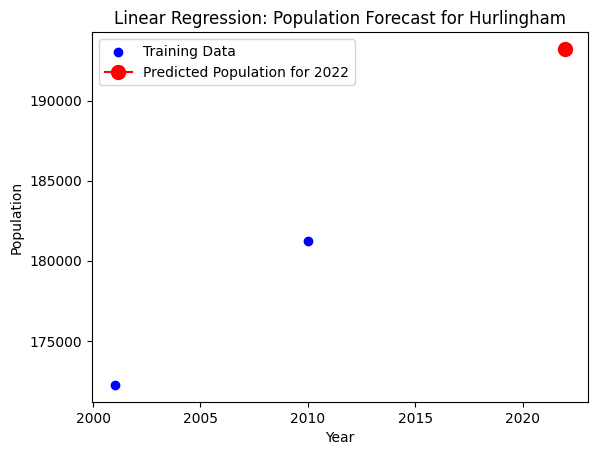

Mean Squared Error (MSE): 947377.7777771734
Root Mean Squared Error (RMSE): 973.3333333330229
Mean Absolute Percentage Error (MAPE): 0.5413783641472306%


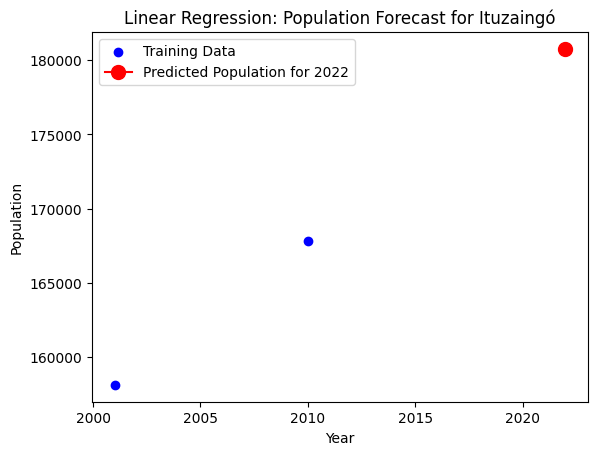

Mean Squared Error (MSE): 104850773.44443172
Root Mean Squared Error (RMSE): 10239.666666666046
Mean Absolute Percentage Error (MAPE): 3.161191001014468%


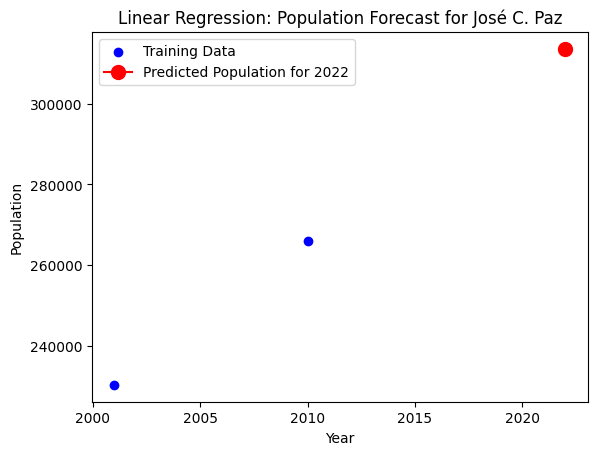

Mean Squared Error (MSE): 399524283627.12366
Root Mean Squared Error (RMSE): 632079.3333333433
Mean Absolute Percentage Error (MAPE): 34.39374663769012%


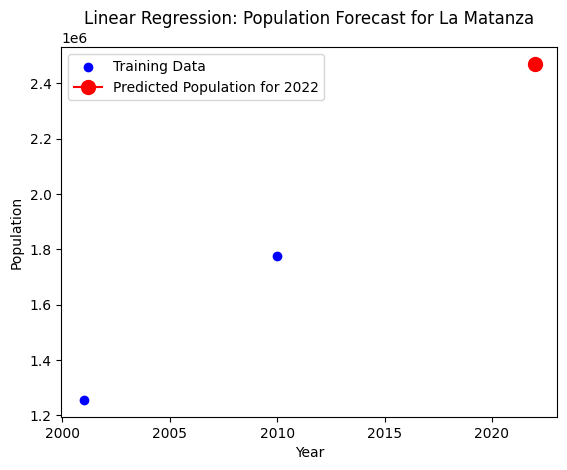

Mean Squared Error (MSE): 29738844.4444436
Root Mean Squared Error (RMSE): 5453.333333333256
Mean Absolute Percentage Error (MAPE): 1.1802448936011947%


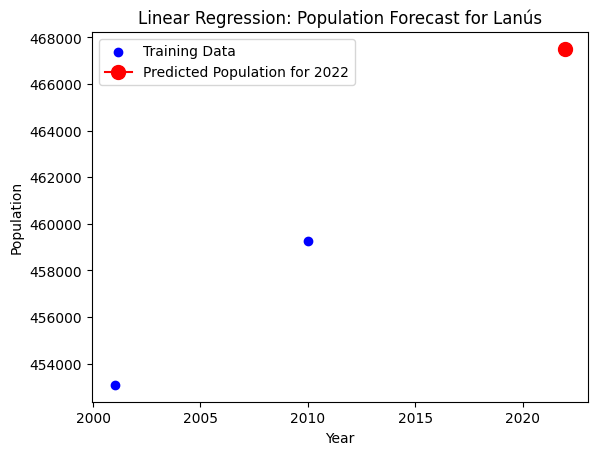

Mean Squared Error (MSE): 2007547765.4444723
Root Mean Squared Error (RMSE): 44805.66666666698
Mean Absolute Percentage Error (MAPE): 6.453079467496288%


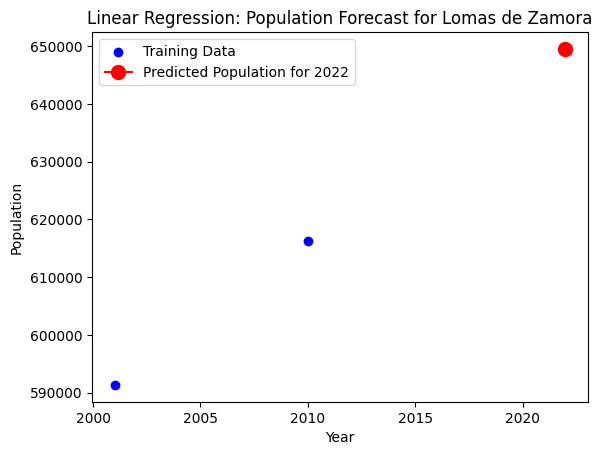

Mean Squared Error (MSE): 164668778.7777698
Root Mean Squared Error (RMSE): 12832.333333333023
Mean Absolute Percentage Error (MAPE): 3.6477461804646616%


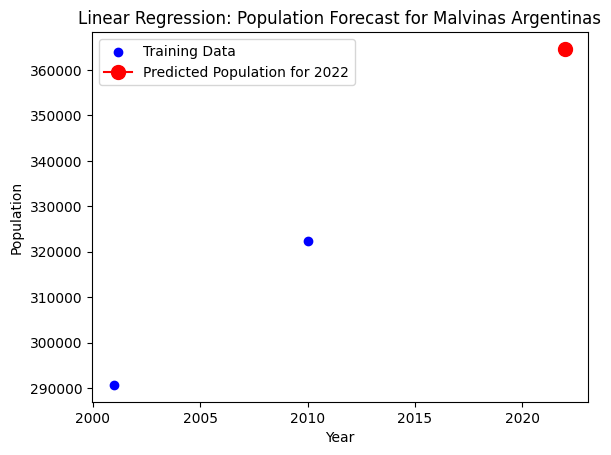

Mean Squared Error (MSE): 660490000.0
Root Mean Squared Error (RMSE): 25700.0
Mean Absolute Percentage Error (MAPE): 4.4248854178503665%


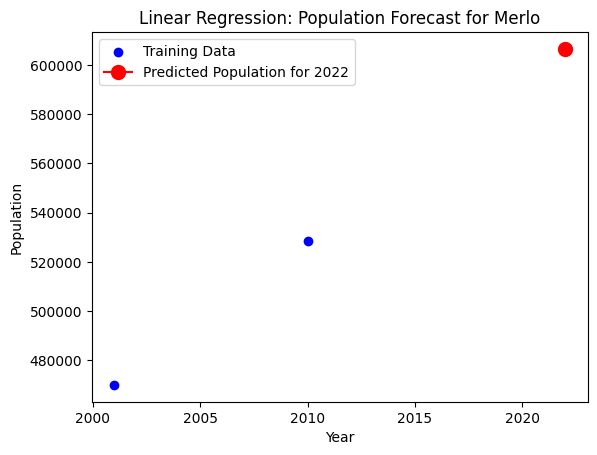

Mean Squared Error (MSE): 669067200.1111432
Root Mean Squared Error (RMSE): 25866.333333333954
Mean Absolute Percentage Error (MAPE): 4.503395580812146%


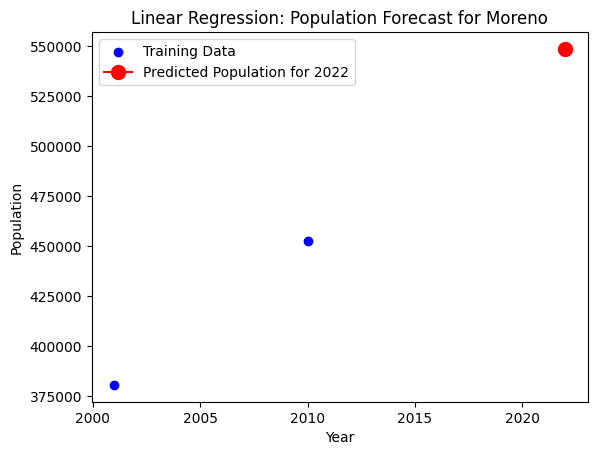

Mean Squared Error (MSE): 6603186.77777698
Root Mean Squared Error (RMSE): 2569.6666666665114
Mean Absolute Percentage Error (MAPE): 0.7689514769573436%


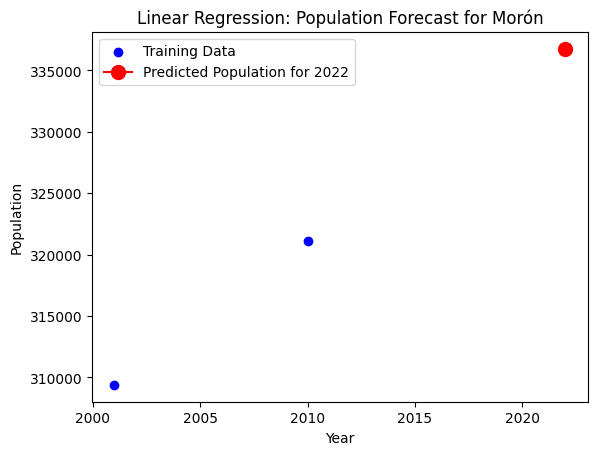

Mean Squared Error (MSE): 1053456849.0
Root Mean Squared Error (RMSE): 32457.0
Mean Absolute Percentage Error (MAPE): 5.10309326977199%


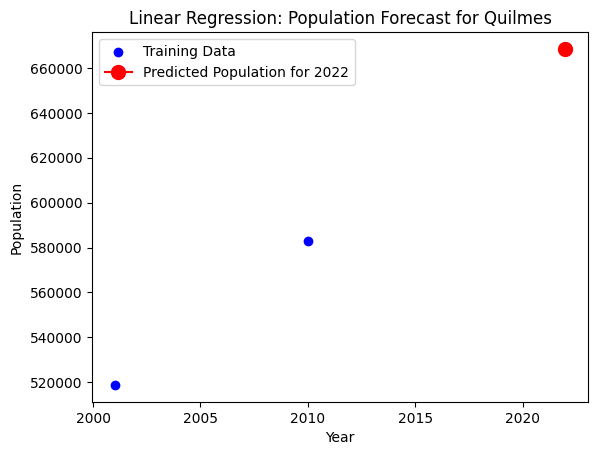

Mean Squared Error (MSE): 47077895.11111324
Root Mean Squared Error (RMSE): 6861.333333333489
Mean Absolute Percentage Error (MAPE): 3.9770312149808076%


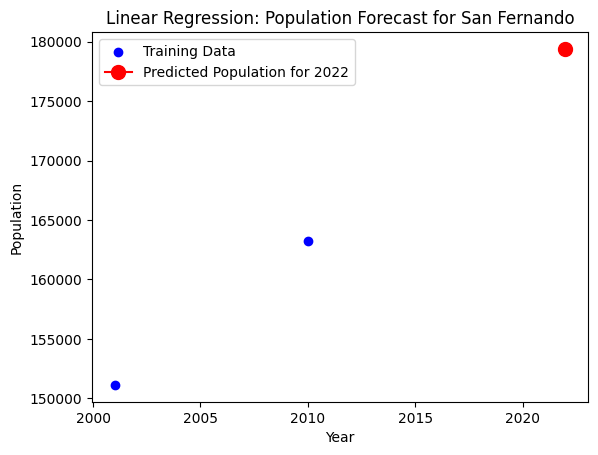

Mean Squared Error (MSE): 16551336.111110954
Root Mean Squared Error (RMSE): 4068.333333333314
Mean Absolute Percentage Error (MAPE): 1.361662153824864%


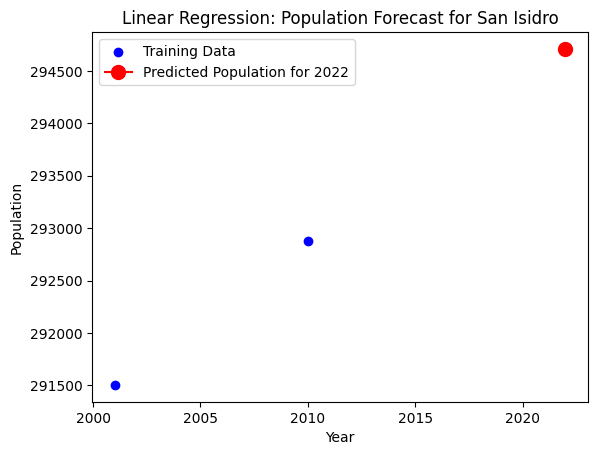

Mean Squared Error (MSE): 369395586.7777897
Root Mean Squared Error (RMSE): 19219.666666666977
Mean Absolute Percentage Error (MAPE): 5.891717629988498%


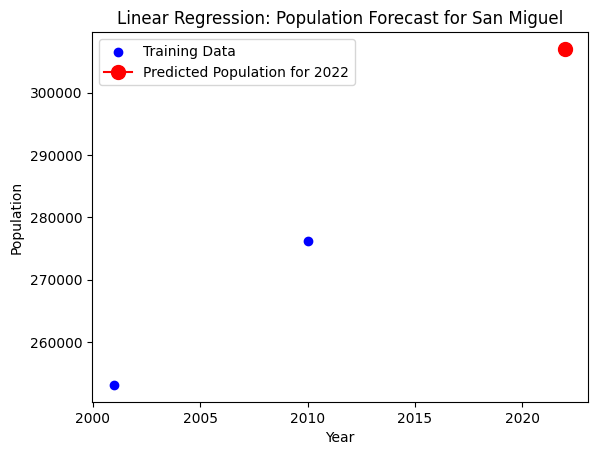

Mean Squared Error (MSE): 829824044.4444087
Root Mean Squared Error (RMSE): 28806.666666666046
Mean Absolute Percentage Error (MAPE): 6.433146859914031%


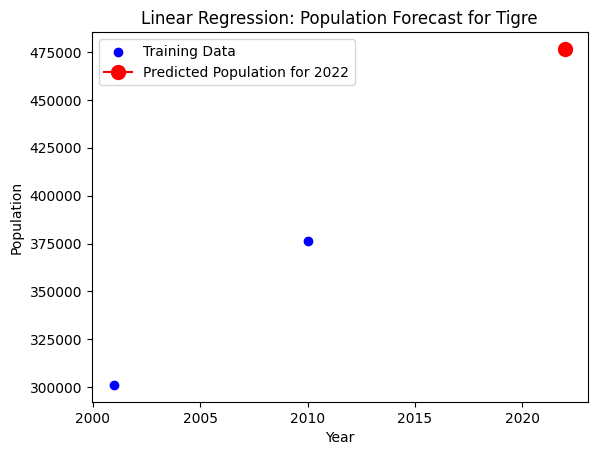

Mean Squared Error (MSE): 462278667.11110944
Root Mean Squared Error (RMSE): 21500.666666666628
Mean Absolute Percentage Error (MAPE): 5.8684542606841115%


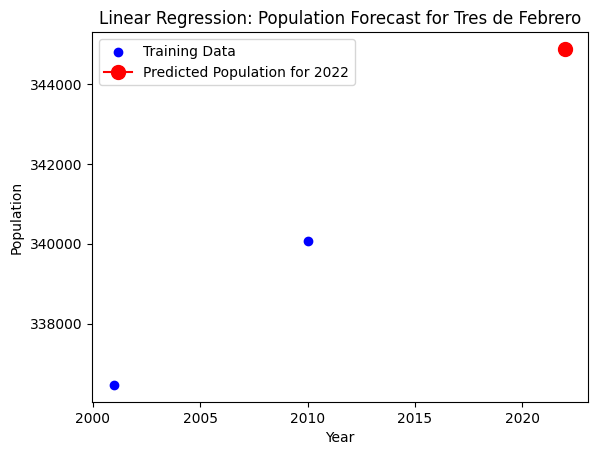

Mean Squared Error (MSE): 412333636.0
Root Mean Squared Error (RMSE): 20306.0
Mean Absolute Percentage Error (MAPE): 7.162357588797573%


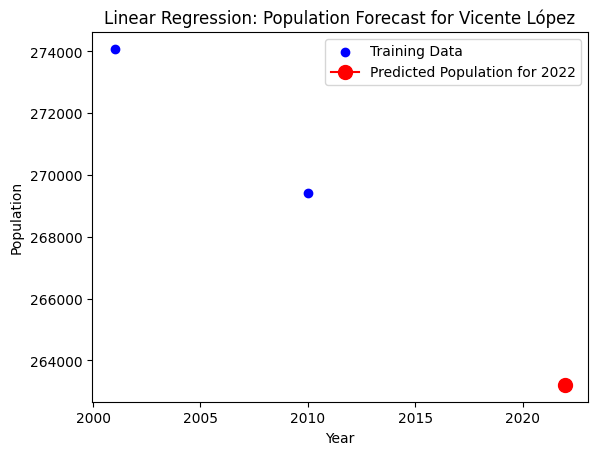

Empty DataFrame
Columns: []
Index: []


In [12]:
def create_dataset(df):
    # Group by 'nam'
    groups = df.groupby('nam')
    datasets = []

    # Iterate over each group
    for name, group in groups:
        # Forecast using linear regression
        forecast_data = linear_regression_forecast(group)

        # Check if forecast data is None
        if forecast_data is None:
            continue

        # Calculate error metrics
        forecast_data['error'] = forecast_data['real'] - forecast_data['prediction']
        forecast_data['mse'] = mean_squared_error(forecast_data['real'], forecast_data['prediction'])
        forecast_data['abs_error'] = forecast_data['error'].abs()

        # Add group name as a column
        forecast_data['nam'] = name

        # Append to the list of datasets
        datasets.append(forecast_data)

    # Concatenate datasets into a single DataFrame
    if datasets:
        result = pd.concat(datasets, ignore_index=True)
    else:
        result = pd.DataFrame()  # Create an empty DataFrame if no data was processed
    return result

# Create the dataset
result_dataset = create_dataset(df)

# Display the resulting dataset
print(result_dataset)


#### 2nd try

In [13]:
from cgi import print_exception


def linear_regression_forecast(df_group):
    # Drop rows with NaN values in the target variable 'pob'
    df_group = df_group.dropna(subset=['pob'])

    if df_group.empty:
        print("No data available for forecasting in this group.")
        return

    # Filter data for years 1990, 2001, and 2010
    X_train = df_group[df_group['anio'].isin([1990, 2001, 2010])]['anio'].values.reshape(-1, 1)
    y_train = df_group[df_group['anio'].isin([1990, 2001, 2010])]['pob'].values

    # Create and fit the Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict population for the year 2022
    X_test = [[2022]]
    y_pred_2022 = model.predict(X_test)
    

    # Calculate error for the year 2022
    actual_population_2022 = df_group[df_group['anio'] == 2022]['pob'].values
    error_2022 = actual_population_2022 - y_pred_2022
    mse = mean_squared_error(actual_population_2022, y_pred_2022).round(1)
    rmse = np.sqrt(mse).round(1)
    mape = np.mean(np.abs((actual_population_2022 - y_pred_2022) / actual_population_2022)).round(4) * 100


    # Create a DataFrame with the forecasted data for the year 2022 and error
    forecast_data = pd.DataFrame({
        'nam': [df_group['nam'].iloc[0]],
        'real_2022': int(actual_population_2022),
        'prediction_2022':int(y_pred_2022),
        'AbsError': error_2022.round(1),
        'MSE':"{:.2e}".format(mse),
        'RMSE':rmse,
        'MAPE':mape
    })

    return forecast_data


C:\Users\Fer\AppData\Local\Temp\ipykernel_10416\3483811153.py:1: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  from cgi import print_exception


In [14]:
# Create an empty list to store the forecast datasets for each 'nam' group
forecast_datasets = []

# Apply the linear_regression_forecast function to each 'nam' group
for name, group in df.groupby('nam'):
    print("Forecast for", name)
    forecast_data = linear_regression_forecast(group)
    forecast_datasets.append(forecast_data)

# Concatenate datasets into a single DataFrame
result_dataset = pd.concat(forecast_datasets, ignore_index=True)

# Display the resulting dataset
print(result_dataset)


Forecast for Almirante Brown
Forecast for Avellaneda
Forecast for Berazategui
Forecast for Esteban Echeverría
Forecast for Ezeiza
Forecast for Florencio Varela
Forecast for General San Martín
Forecast for Hurlingham
Forecast for Ituzaingó
Forecast for José C. Paz
Forecast for La Matanza
Forecast for Lanús
Forecast for Lomas de Zamora
Forecast for Malvinas Argentinas
Forecast for Merlo
Forecast for Moreno
Forecast for Morón
Forecast for Quilmes
Forecast for San Fernando
Forecast for San Isidro
Forecast for San Miguel
Forecast for Tigre
Forecast for Tres de Febrero
Forecast for Vicente López
                    nam  real_2022  prediction_2022  AbsError       MSE  \
0       Almirante Brown     585852           602696  -16844.7  2.84e+08   
1            Avellaneda     370939           360939    9999.3  1.00e+08   
2           Berazategui     360582           372685  -12103.3  1.46e+08   
3    Esteban Echeverría     339030           376939  -37909.0  1.44e+09   
4                Ezeiza     

C:\Users\Fer\AppData\Local\Temp\ipykernel_10416\3483811153.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'real_2022': int(actual_population_2022),
C:\Users\Fer\AppData\Local\Temp\ipykernel_10416\3483811153.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction_2022':int(y_pred_2022),
C:\Users\Fer\AppData\Local\Temp\ipykernel_10416\3483811153.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'real_2022': int(actual_population_2022),
C:\Users\Fer\

In [15]:
dataframe_to_latex(result_dataset)

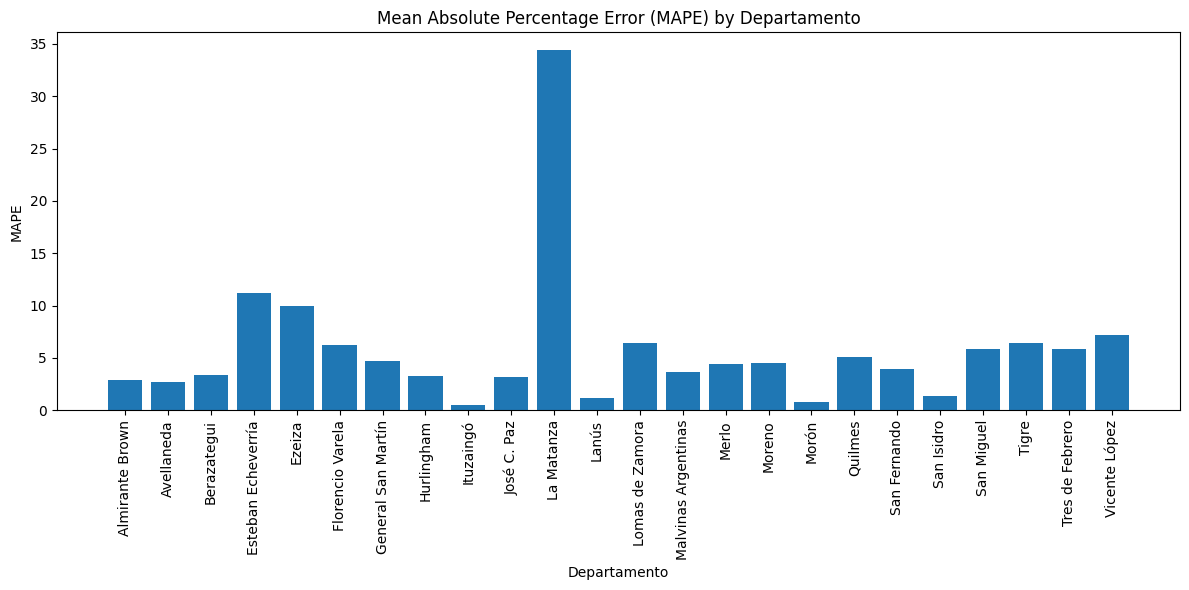

In [16]:
# Extract 'nam' values and their corresponding MAPE values
nam_values = result_dataset['nam'].unique()
mape_values = result_dataset.groupby('nam')['MAPE'].mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(nam_values, mape_values)
plt.xlabel('Departamento')
plt.ylabel('MAPE')
plt.title('Mean Absolute Percentage Error (MAPE) by Departamento')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


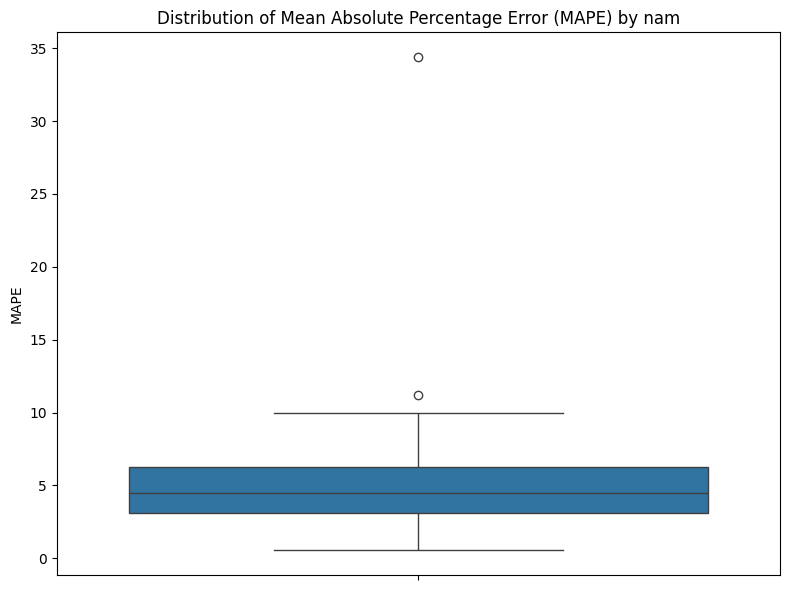

In [17]:
# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(y='MAPE', data=result_dataset)
plt.ylabel('MAPE')
plt.title('Distribution of Mean Absolute Percentage Error (MAPE) by nam')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


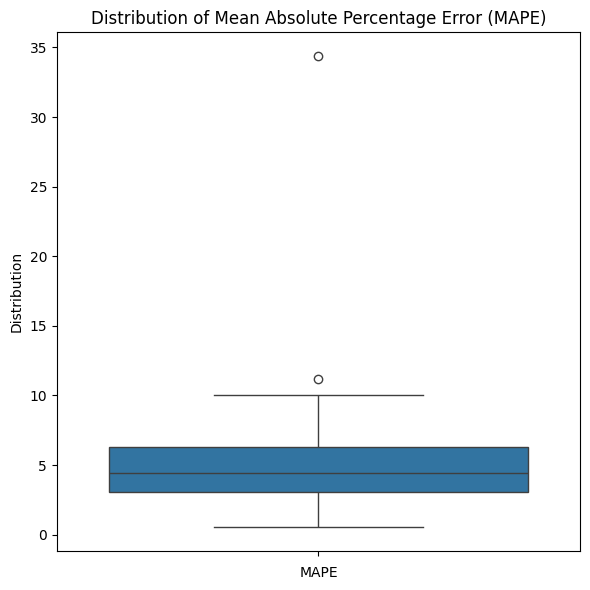

In [18]:
# Plotting MAPE series
plt.figure(figsize=(6, 6))
sns.boxplot(result_dataset['MAPE'], orient='v',)
plt.xlabel('MAPE')
plt.ylabel('Distribution')
plt.title('Distribution of Mean Absolute Percentage Error (MAPE)')
plt.tight_layout()





In [19]:
mape_stats = result_dataset['MAPE'].describe()
print(mape_stats)


count    24.000000
mean      5.799583
std       6.631455
min       0.540000
25%       3.090000
50%       4.460000
75%       6.265000
max      34.390000
Name: MAPE, dtype: float64


In [26]:
# Create a copy of merged_df to work with
extended_df = merged_df.copy()

# Merge the result_dataset with extended_df based on 'nam'
extended_df = pd.merge(extended_df, result_dataset[['nam', 'prediction_2022', 'MAPE']], how='left', left_on='nam', right_on='nam')

# Rename the columns to match the expected names
extended_df.rename(columns={'prediction_2022': 'Pred_LR', 'MAPE': 'MAPE_LR'}, inplace=True)

# Set the values of 'Pred_LR' and 'MAPE_LR' where 'anio' is equal to 2022
extended_df['Pred_LR'] = extended_df.loc[extended_df['anio'] == 2022, 'Pred_LR'].fillna(0)
extended_df['MAPE_LR'] = extended_df.loc[extended_df['anio'] == 2022, 'MAPE_LR'].fillna(0)

# Fill missing values with 0
extended_df['Pred_LR'] = extended_df['Pred_LR'].fillna(0)

# Convert to integer, handling non-finite values
extended_df['Pred_LR'] = extended_df['Pred_LR'].astype(float).round().astype(int)

# Display the updated DataFrame
print(extended_df)



                nam cod_depto  anio       pob       var       muj   vivpart  \
0   Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
1   Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
2   Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
3   Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
4        Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
..              ...       ...   ...       ...       ...       ...       ...   
91  Tres de Febrero     06840  1991  349376.0  167417.0  181959.0       NaN   
92    Vicente López     06861  2001  274082.0  127238.0  146844.0  108947.0   
93    Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
94    Vicente López     06861  1991  289505.0  135426.0  154079.0       NaN   
95    Vicente López     06861  2010  269420.0  125792.0  143628.0  114747.0   

    vivtotal     sup ind_masc dens_pob   TMI   TGF 

In [27]:
# Define the file path
file_path = 'ext_LR.csv'

# Export the DataFrame to a CSV file
extended_df.to_csv(file_path, index=False)

print("CSV file has been saved successfully!")


CSV file has been saved successfully!


In [ ]:
# Define the file path
file_path = 'ext_LR.csv'

# Export the DataFrame to a CSV file
extended_df.to_csv(file_path, index=False)

print("CSV file has been saved successfully!")


CSV file has been saved successfully!
